<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/RL-PortfolioOpt_StocVol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy



In [20]:
#Setting seed
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(0)

In [21]:
# 1 asset 
params = {
    "S0" : np.array([100]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([0.8]),
    "rho" : np.array([[1]]),
    "rf" : 0.01,
    "delta" : np.array([0.7])
    }
params_Q = copy.copy(params)
params_Q["mu"] = np.array([params_Q["rf"]])


# ## 2 assets 
# params = {
#     "S0" : np.array([1, 1]),
#     "mu" : np.array([0.05, 0.05]),
#     "sigma" : np.array([0.05, 0.9]),
#     "rho" : np.array([[1, .25],[.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.5, 0.5])
#     }
# params_Q = copy.copy(params)
# params_Q["mu"] = np.array([params_Q["rf"],params_Q["rf"]])

## 4 assets 
# params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.10 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }
#params_Q = copy.copy(params)
#params_Q["mu"] = np.array([params_Q["rf"], params_Q["rf"], params_Q["rf"], params_Q["rf"]])

# print(params)

# print(params_Q)

In [22]:
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

In [23]:
## Function for Heston vol 

from IPython.core.debugger import set_trace

params = {
    "S0" : np.array([100]),
    "mu" : np.array([0.05]),    
    "rho" : -.2,
    "kappa" : np.array([[2]]),
    "theta" : np.array([[0.3]]),
    "xi" : np.array([[1.0]]),
    "v0" : np.array([0.2**2]),
    "delta" : np.array([0.7]),
    "rf" : 0.01
    }

# params = {
#     "S0" : np.array([100]),
#     "mu" : np.array([0.05]),
#     "sigma" : np.array([0.8]),
#     "rho" : -.2,
#     "kappa" : np.array([[.3]]),
#     "theta" : np.array([[.2]]),
#     "xi" : np.array([[.2]]),
#     "v0" : np.array([0.2]),
#     "delta" : np.array([0.7]),
#     "rf" : 0.01,
#     }

params_Q = copy.copy(params)    

def SimPathStocVol ( Ndt, params, T, Nsims):

    # Generate a Monte Carlo simulation for the Heston model
    #set_trace()
    dt = T/Ndt
    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, params["rho"]], [params["rho"], 1]])
    W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
    W_S = W[:,:,0]
    W_v = W[:,:,1]

    # Generate paths
    vt    = np.zeros((Ndt +1, Nsims))
    vt[0,:] = params["v0"]
    St    = np.zeros((Ndt +1, Nsims))
    St[0,:] = params["S0"]
    #print(St[0])
    #set_trace()
    for t in range(1, Ndt +1):        
#         vt[t,:] = np.abs(vt[t-1,:] + params["kappa"]*(params["theta"]-np.abs(vt[t-1,:]))*dt \
#                          + params["xi"]*np.sqrt(np.abs(vt[t-1,:]))*W_v[t,:]*np.sqrt(dt))                                            
#         vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]) )*dt\
#          + params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt)
        #With Milestein correction term 
#         vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]) )*dt \
#         + params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt) +\
#         0.25 * params["xi"]**2*dt(W_v[t,:]**2-1)
        
        vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]))*dt + \
        params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt) \
        + 0.25 * params["xi"]**2*dt*(W_v[t,:]**2-1) 
        
        
        St[t,:] = St[t-1,:]*np.exp((params["mu"] - 0.5*vt[t-1,:])*dt + np.sqrt(vt[t-1,:]*dt)*W_S[t,:])
        #print(St[t-1])
        
    #set_trace()
    #import pandas as pd
    #pd.DataFrame(vt).to_csv('vol.csv')
        
    St = St.reshape(Ndt +1, Nsims, 1 )
    t = np.linspace(0,T,Ndt+1)    
    return t, St

In [24]:
Ndt = 252
Nsims = 1000
MU  = np.array([0, 0])
COV = np.matrix([[1, params["rho"]], [params["rho"], 1]])
W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
W[:,:,0].shape

(253, 1000)

In [25]:
t, S = SimPathStocVol( Ndt=252, params = params, T=5, Nsims= 100)

In [26]:
S.shape

(253, 100, 1)

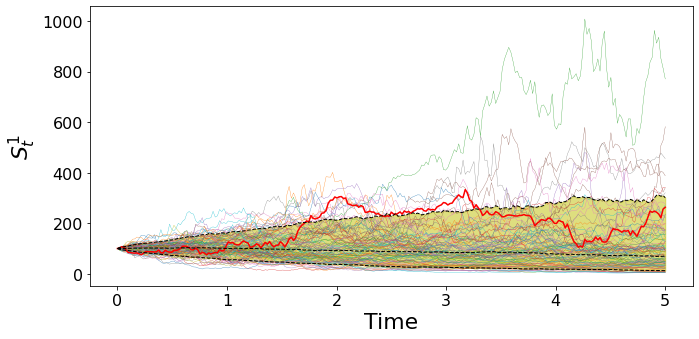

In [27]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPathStocVol(Ndt=252, params = params, T=5, Nsims = 1000)
#t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [28]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [29]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* torch.mean(X[X<=LQtl]) \
                        + (1-p) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [30]:
# from a minibatch compute the Wasserstein Distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

In [31]:
# given an ANN run a simulation and compute the riskmeasure
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
    
    t, S = SimPathStocVol(Ndt, params, T=T, Nsims=Nsims)  
      
    #t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    #set_trace()
    # initial investment amount
    X0 = 1
    
    num_asset = S.shape[2]
    dt = t[1]-t[0]
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
    #print(torch.mean(BenchmarkVal_path,1))
    #
    # Getting the portfolio weights using benchmark value and time as features
    #
    x=np.zeros((Ndt+1, Nsims, 2))   
    #set_trace()
    
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    xt[:,:,1] = BenchmarkVal_path/X0
    
    wt = net(xt)    
    
    # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)
        
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(PortfolioVal_T, BenchmarkVal_T)
    RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
    
    return wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, t, BenchmarkVal_path.cpu().detach().numpy(), PortfolioVal_path.cpu().detach().numpy()

In [32]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists(X, Y, t, X_path, Y_path):
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    bins = np.linspace(0,4,50)
    
    sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
    sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  
    
    plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
    plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)
    
    plt.legend()
    plt.xlim(0,4)
    

    plt.subplot(1,3,2)
    plt.fill_between(t, np.quantile(X_path,0.1,axis=1).T, np.quantile(X_path,0.9,axis=1).T, color='y', alpha=0.5)
    plt.fill_between(t, np.quantile(Y_path,0.1,axis=1).T, np.quantile(Y_path,0.9,axis=1).T, color='g', alpha=0.5)
    plt.plot(t,X_path[:,0], label='Benchmark', color='r')
    plt.plot(t,np.quantile(X_path,[0.1,0.5,0.9],axis=1).T, '--y')
    plt.plot(t,Y_path[:,0], label='Portfolio', color='k')
    plt.plot(t,np.quantile(Y_path,[0.1,0.5,0.9],axis=1).T, '--g')
    
    plt.legend()
    
    
    plt.subplot(1,3,3)
    xs = [min(Xcp), max(Xcp)]
    plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


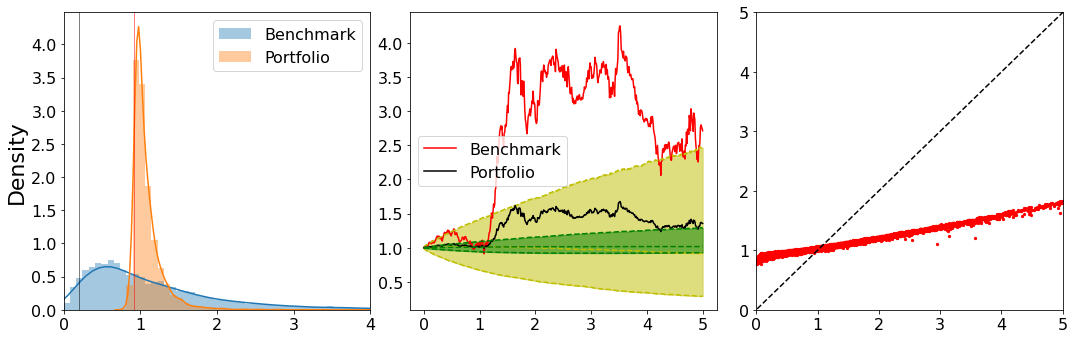

In [33]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)


In [34]:
PortfolioVal_path.shape

(501, 10000)

In [35]:
torch.cuda.is_available()

True

...........10 duaration =  10.368  secs
Wass Dist: 0.632 Risk Measure: -10.558 Loss: 52.666


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


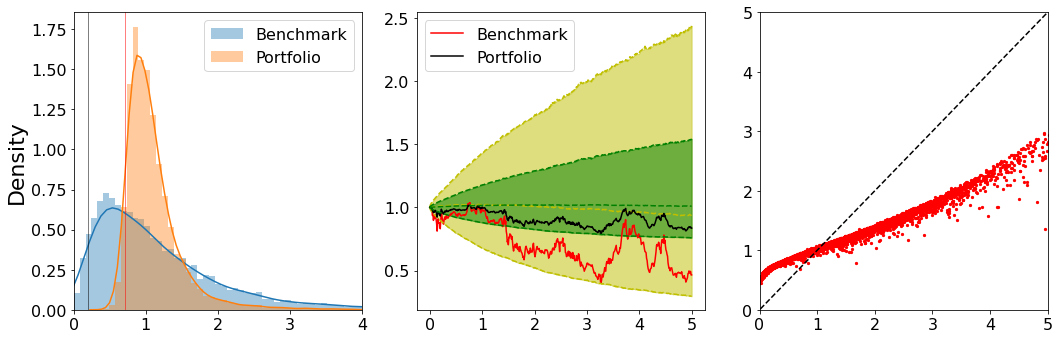

1.1499755 1.0621686

..........20 duaration =  11.713  secs
Wass Dist: 0.603 Risk Measure: -10.509 Loss: 49.782


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


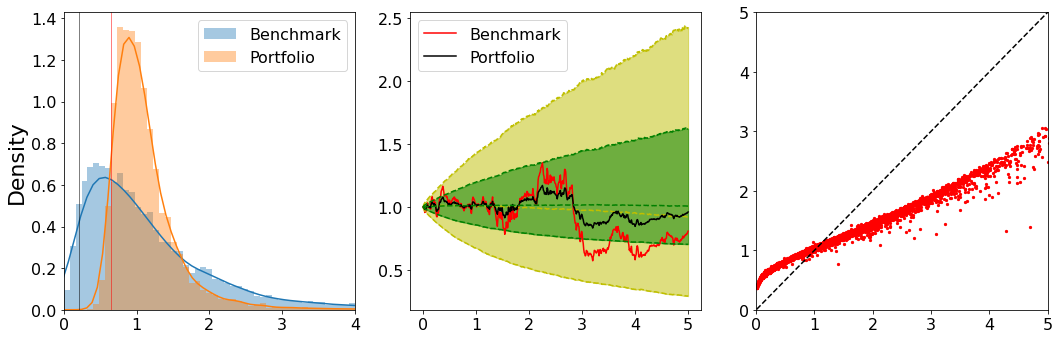

1.1594474 1.0783385

..........30 duaration =  11.682  secs
Wass Dist: 0.685 Risk Measure: -10.165 Loss: 58.315


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


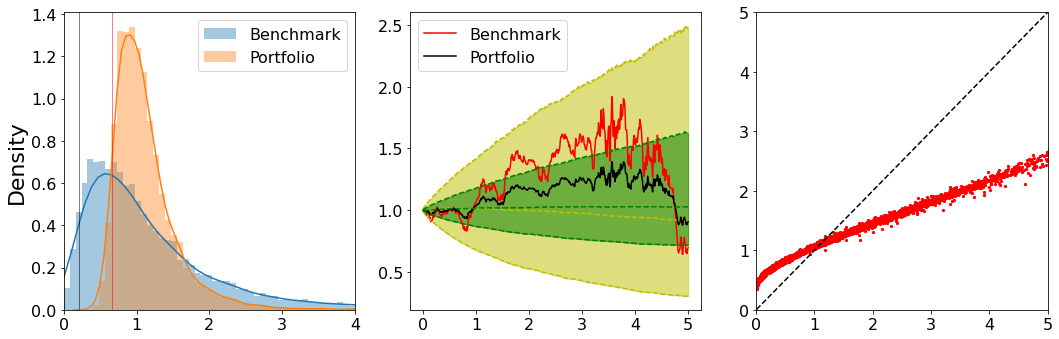

1.1374375 1.0576569

..........40 duaration =  11.667  secs
Wass Dist: 0.627 Risk Measure: -10.106 Loss: 52.579


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


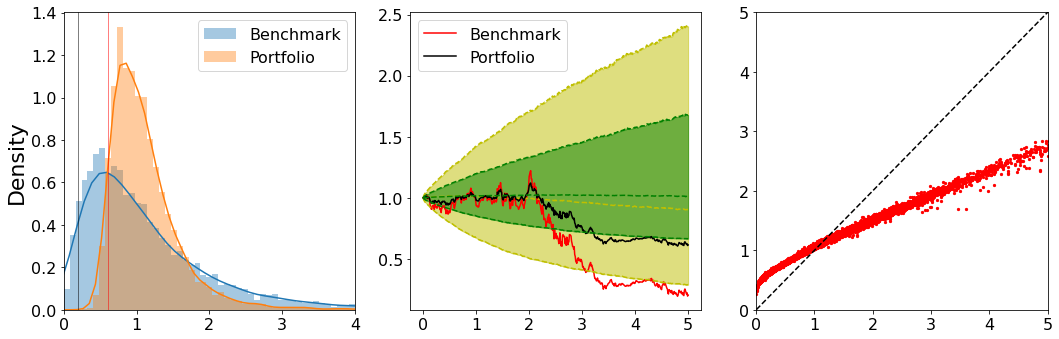

1.1420772 1.0681021

..........50 duaration =  11.562  secs
Wass Dist: 0.395 Risk Measure: -10.428 Loss: -10.428


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


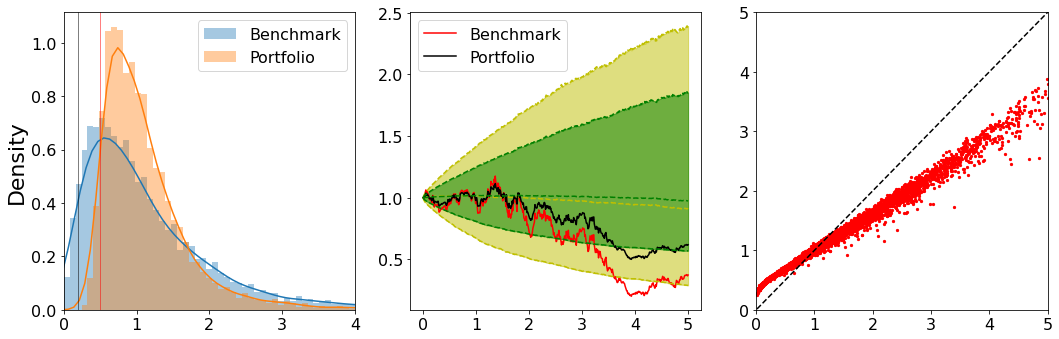

1.1497736 1.0936247

..........60 duaration =  11.720  secs
Wass Dist: 0.392 Risk Measure: -11.251 Loss: -11.251


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


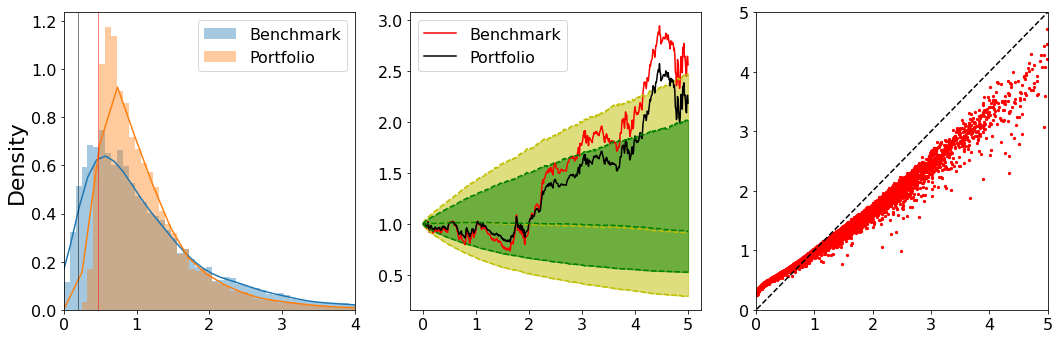

1.1374774 1.0953921

..........70 duaration =  11.569  secs
Wass Dist: 0.385 Risk Measure: -10.795 Loss: -10.795


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


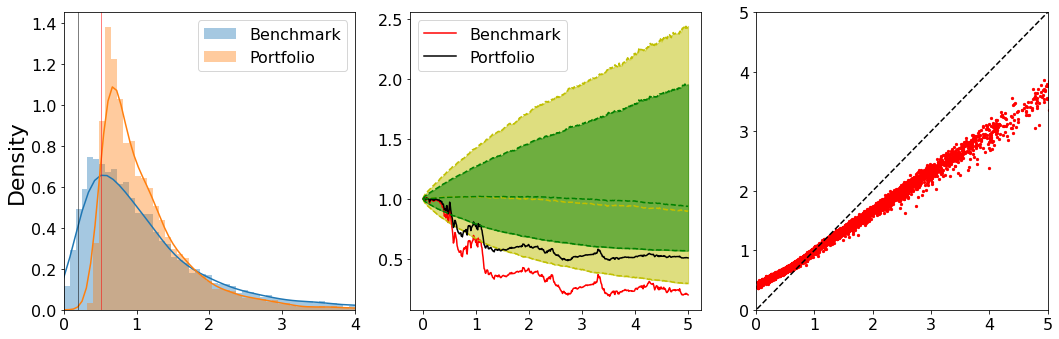

1.1454446 1.09469

..........80 duaration =  11.489  secs
Wass Dist: 0.371 Risk Measure: -10.772 Loss: -10.772


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


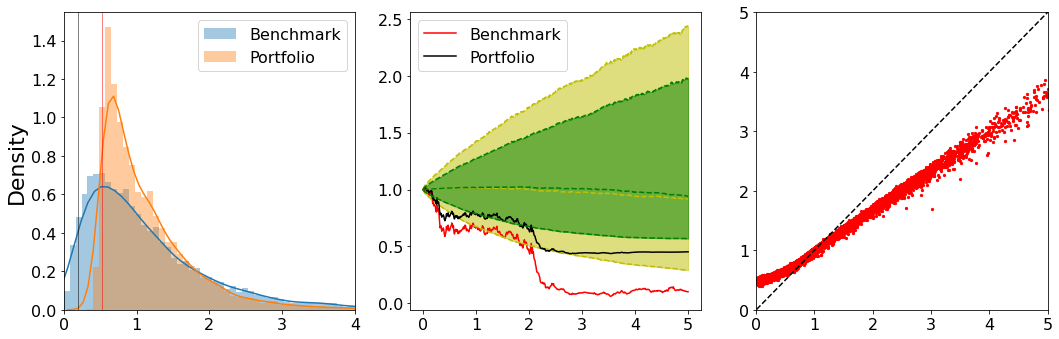

1.1576542 1.1063553

..........90 duaration =  11.524  secs
Wass Dist: 0.348 Risk Measure: -11.347 Loss: -11.347


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


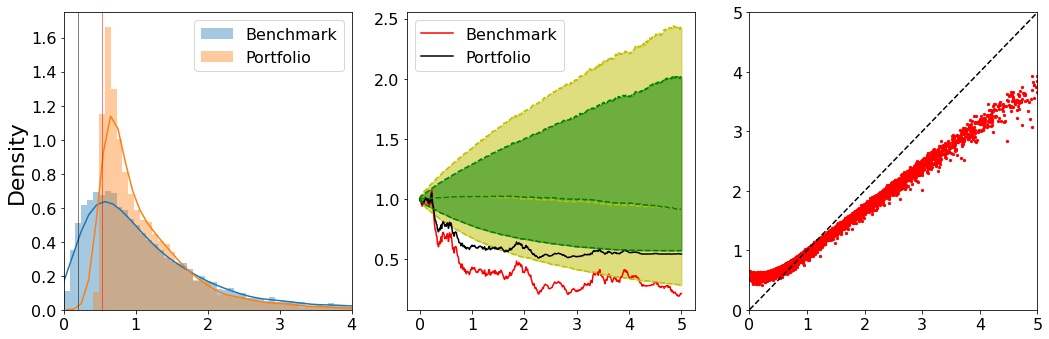

1.1446402 1.097514

..........100 duaration =  11.505  secs
Wass Dist: 0.434 Risk Measure: -11.650 Loss: 31.781


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


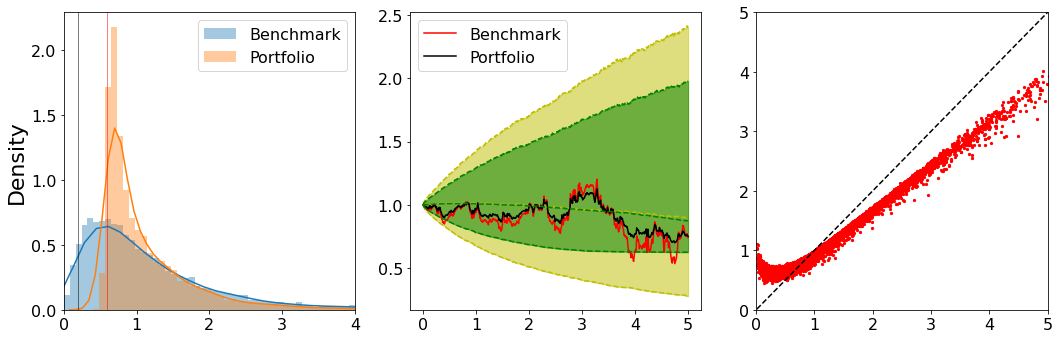

1.142248 1.0938714

..........110 duaration =  11.375  secs
Wass Dist: 0.322 Risk Measure: -11.752 Loss: -11.752


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


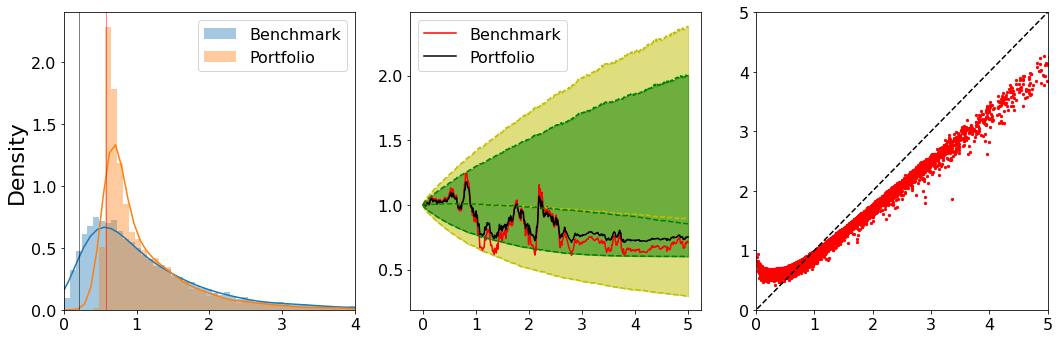

1.1486679 1.10244

..........120 duaration =  11.532  secs
Wass Dist: 0.388 Risk Measure: -11.741 Loss: -11.741


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


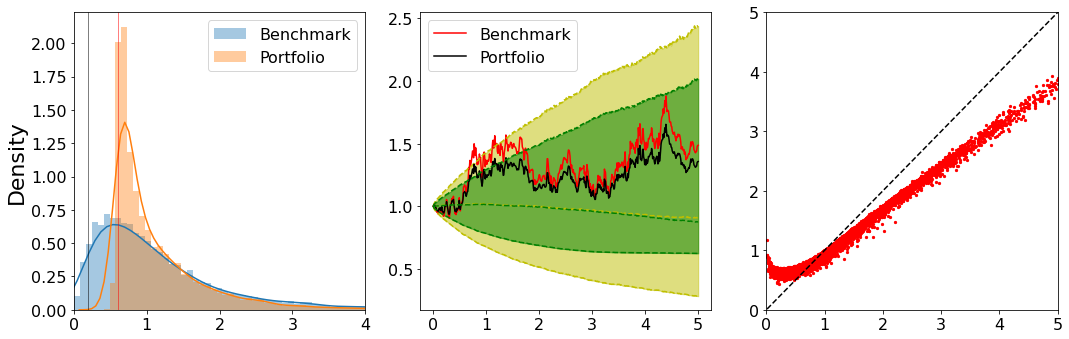

1.1394278 1.0880332

..........130 duaration =  11.398  secs
Wass Dist: 0.340 Risk Measure: -11.493 Loss: -11.493


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


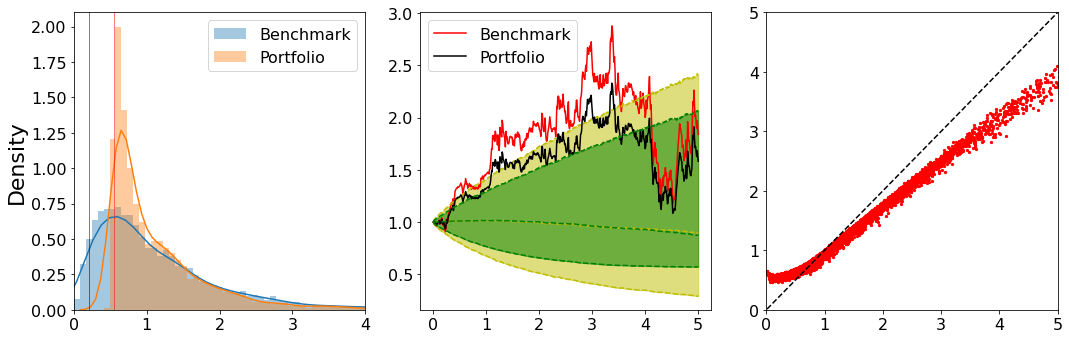

1.1614307 1.1127299

..........140 duaration =  11.430  secs
Wass Dist: 0.297 Risk Measure: -11.986 Loss: -11.986


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


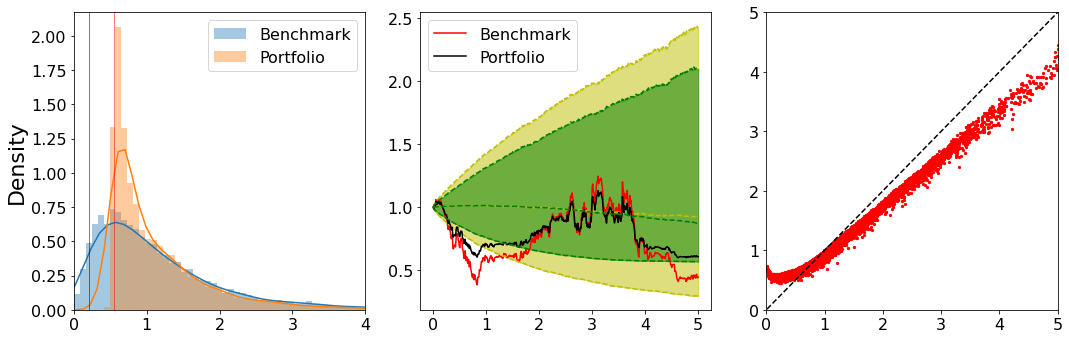

1.141499 1.101736

..........150 duaration =  11.451  secs
Wass Dist: 0.280 Risk Measure: -12.061 Loss: -12.061


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


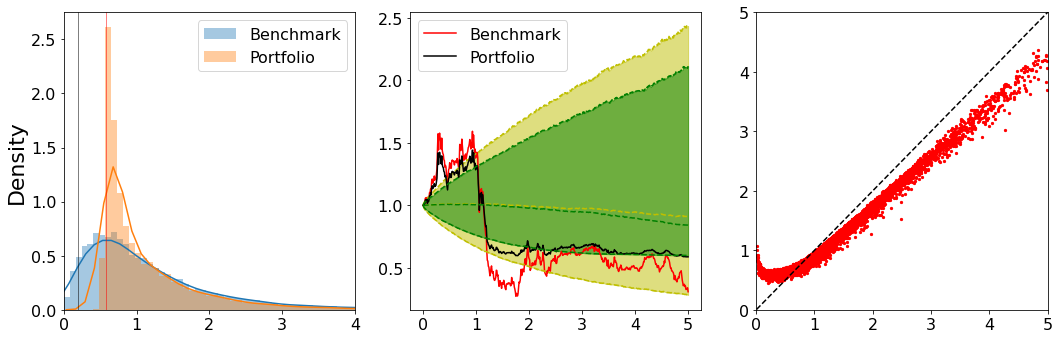

1.1389822 1.1000738

..........160 duaration =  11.166  secs
Wass Dist: 0.295 Risk Measure: -12.268 Loss: -12.268


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


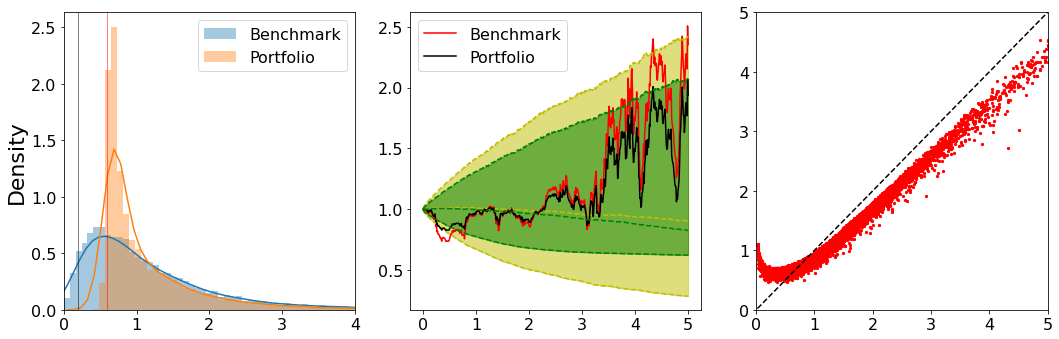

1.1521285 1.1043403

..........170 duaration =  11.292  secs
Wass Dist: 0.299 Risk Measure: -12.819 Loss: -12.819


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


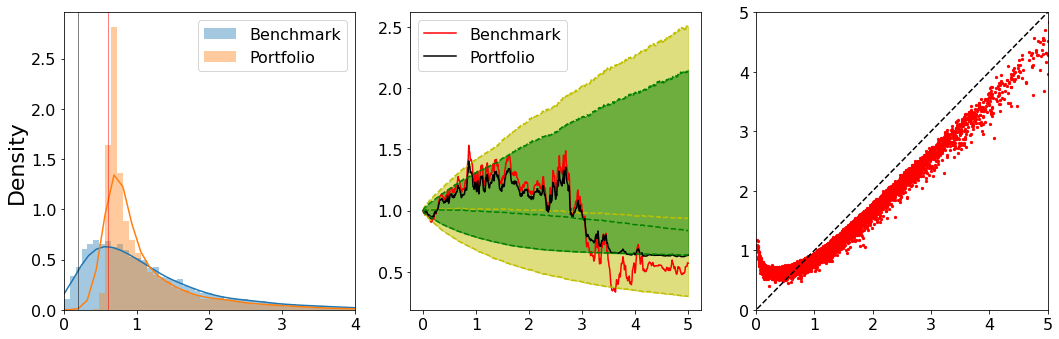

1.1453793 1.097391

..........180 duaration =  11.352  secs
Wass Dist: 0.399 Risk Measure: -12.019 Loss: -12.019


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


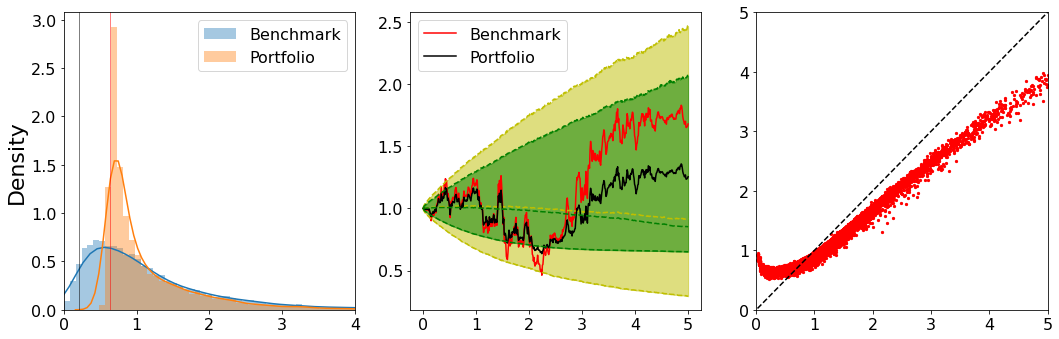

1.1526896 1.1001791

..........190 duaration =  11.340  secs
Wass Dist: 0.233 Risk Measure: -11.596 Loss: -11.596


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


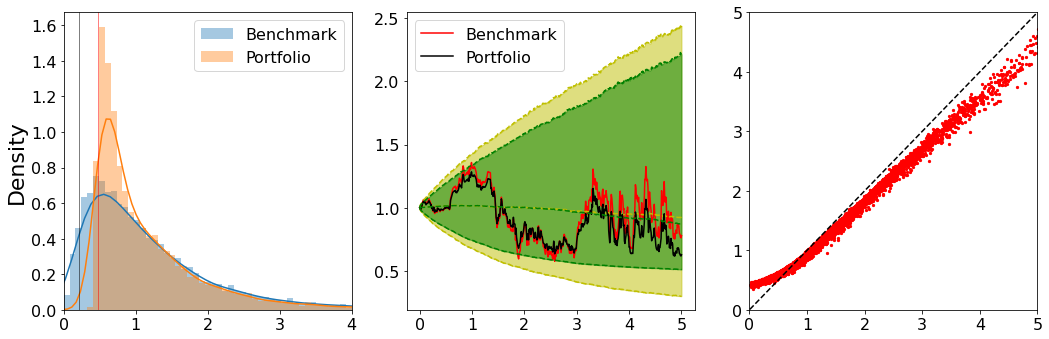

1.1442614 1.1133401

..........200 duaration =  11.443  secs
Wass Dist: 0.185 Risk Measure: -11.887 Loss: -11.887


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


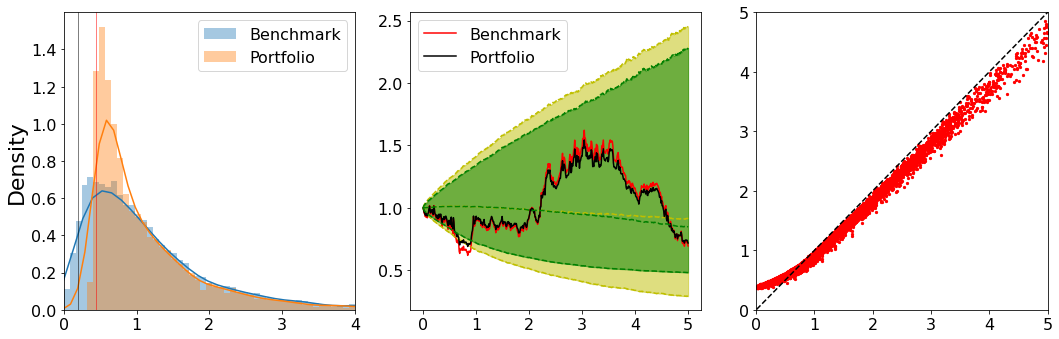

1.1626356 1.1370898

..........210 duaration =  11.360  secs
Wass Dist: 0.162 Risk Measure: -12.458 Loss: -12.458


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


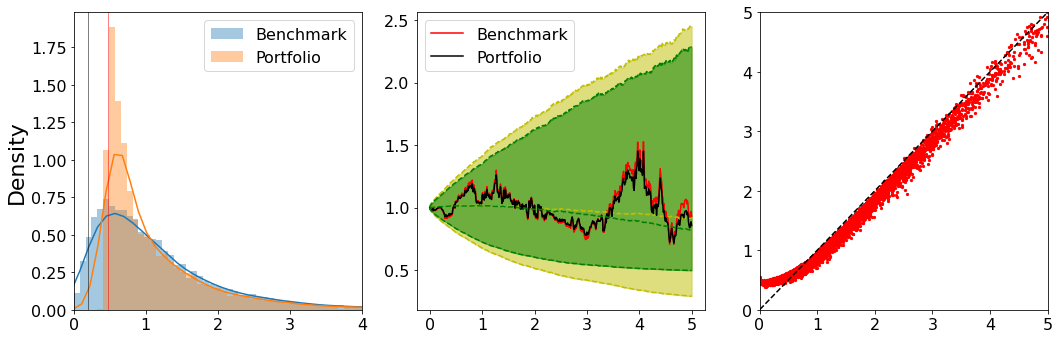

1.1455547 1.1232482

..........220 duaration =  11.131  secs
Wass Dist: 0.198 Risk Measure: -12.814 Loss: -12.814


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


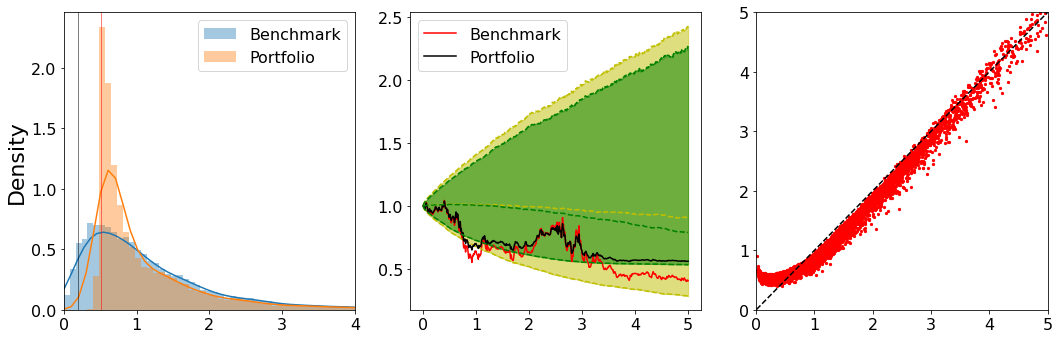

1.1613448 1.1395196

..........230 duaration =  11.399  secs
Wass Dist: 0.442 Risk Measure: -13.302 Loss: 30.878


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


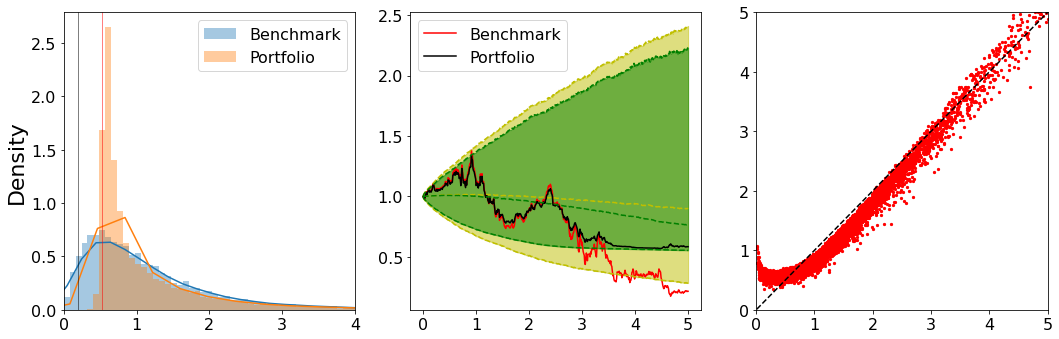

1.1338066 1.1064439

..........240 duaration =  11.417  secs
Wass Dist: 1.007 Risk Measure: -12.237 Loss: 88.509


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


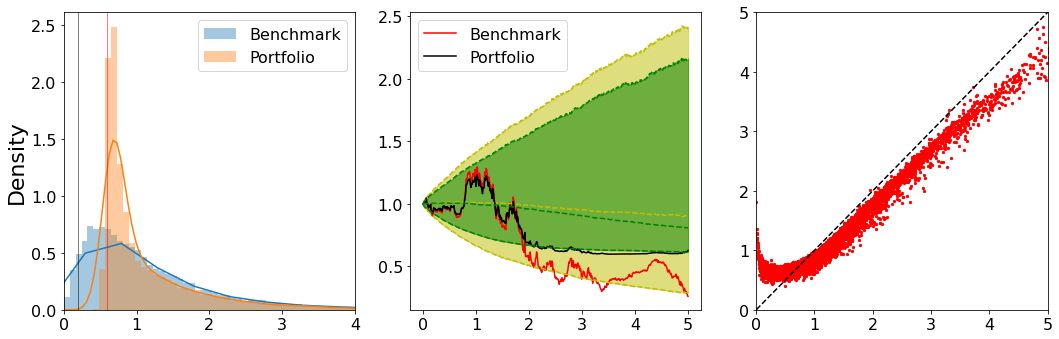

1.1349621 1.0950549

..........250 duaration =  11.335  secs
Wass Dist: 0.281 Risk Measure: -12.542 Loss: -12.542


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


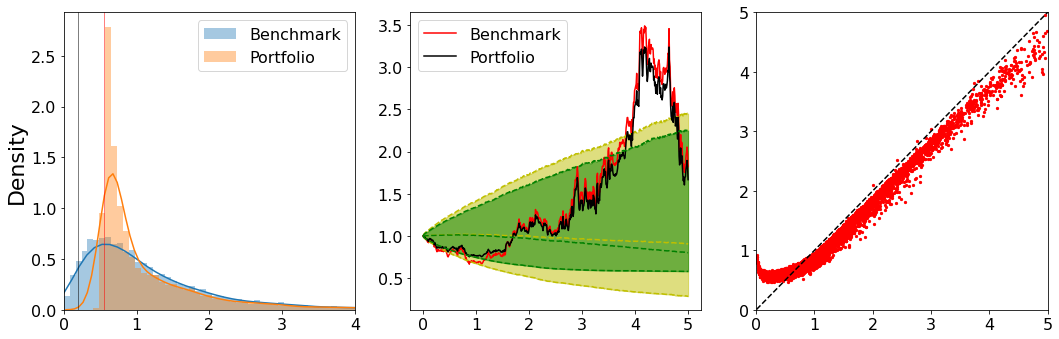

1.1386882 1.106006

..........260 duaration =  11.686  secs
Wass Dist: 0.388 Risk Measure: -13.810 Loss: -13.810


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


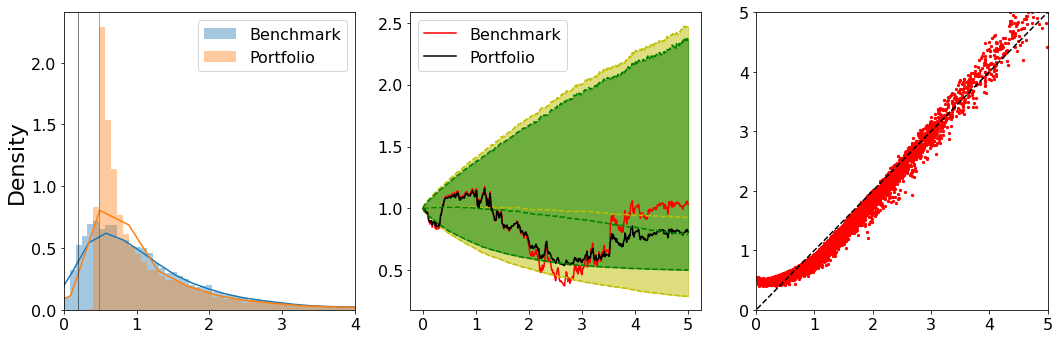

1.1362599 1.125199

..........270 duaration =  11.383  secs
Wass Dist: 0.226 Risk Measure: -13.554 Loss: -13.554


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


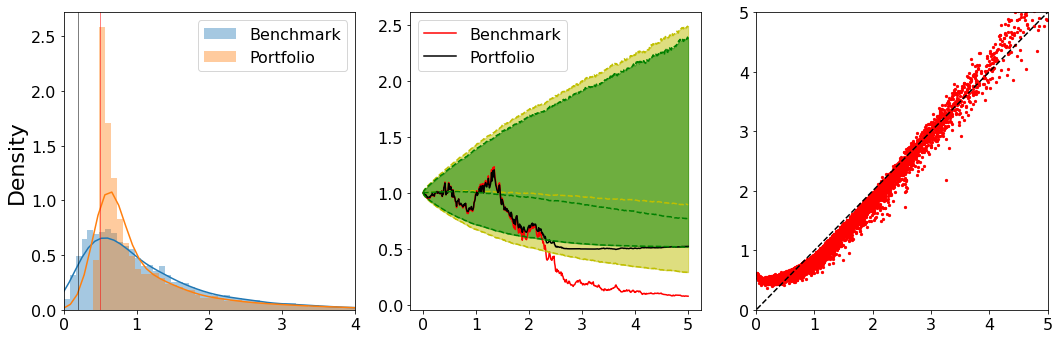

1.1565812 1.1412938

..........280 duaration =  11.538  secs
Wass Dist: 0.682 Risk Measure: -10.856 Loss: 57.363


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


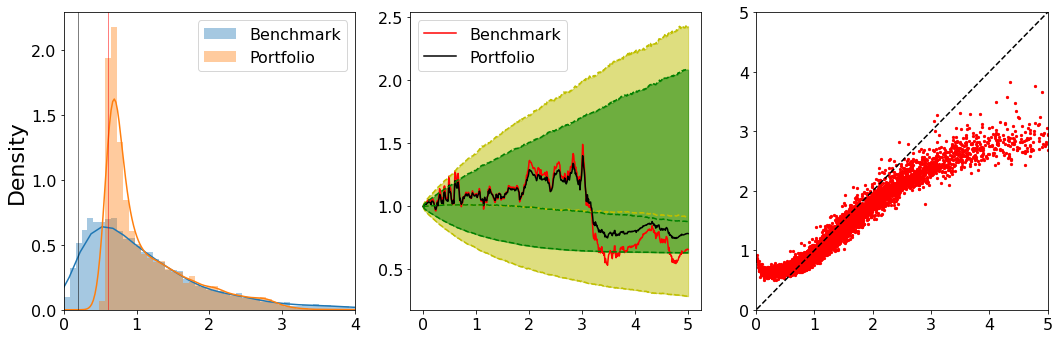

1.167055 1.098544

..........290 duaration =  11.312  secs
Wass Dist: 0.751 Risk Measure: -9.898 Loss: 65.165


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


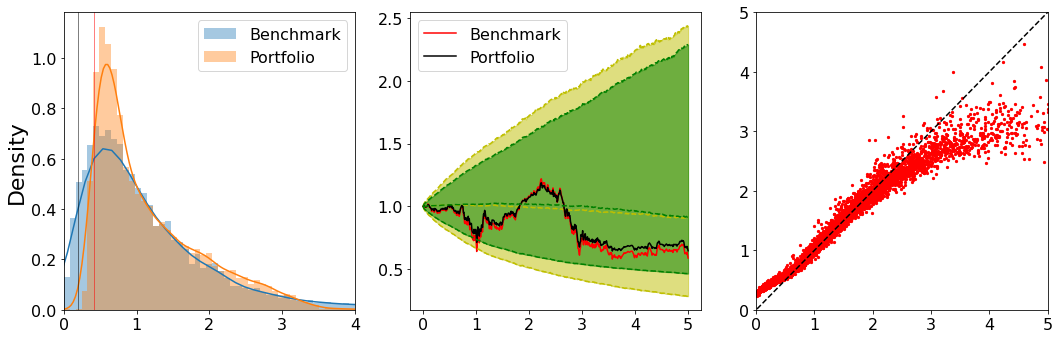

1.1363482 1.0988821

..........300 duaration =  11.290  secs
Wass Dist: 0.352 Risk Measure: -12.013 Loss: -12.013


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


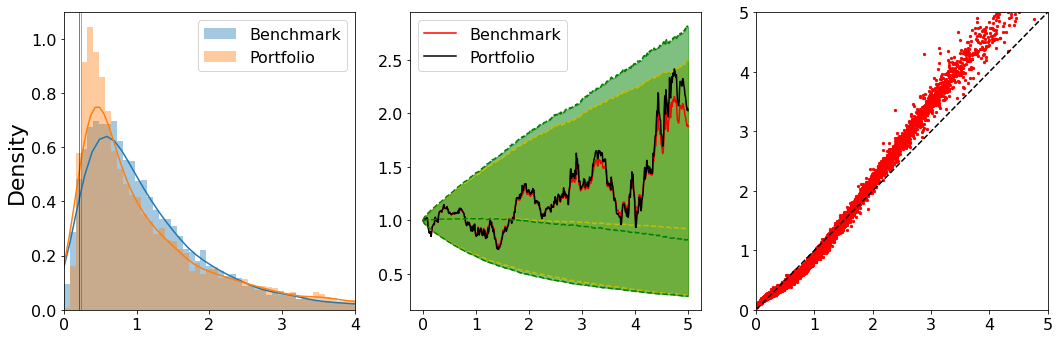

1.150591 1.1691812

..........310 duaration =  10.985  secs
Wass Dist: 0.427 Risk Measure: -13.016 Loss: 29.669


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


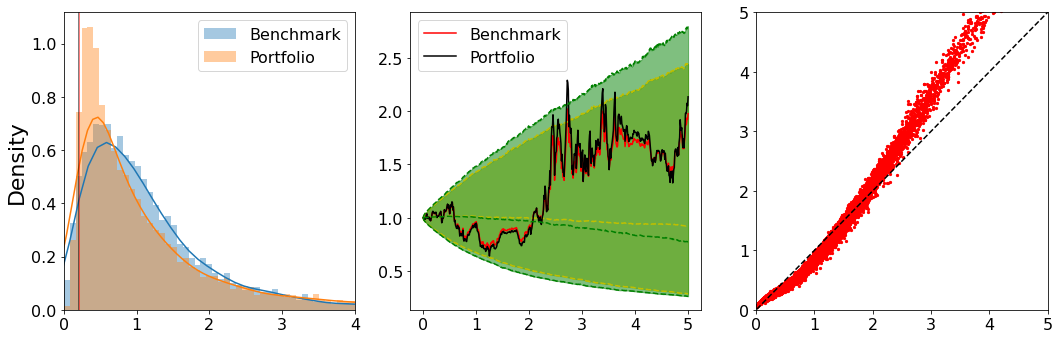

1.1468519 1.1700248

..........320 duaration =  11.292  secs
Wass Dist: 0.232 Risk Measure: -12.382 Loss: -12.382


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


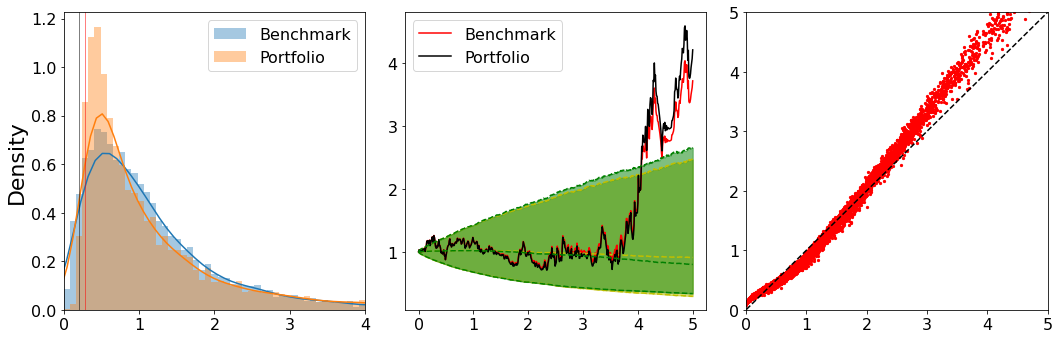

1.1601363 1.1713594

..........330 duaration =  11.188  secs
Wass Dist: 0.273 Risk Measure: -12.741 Loss: -12.741


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


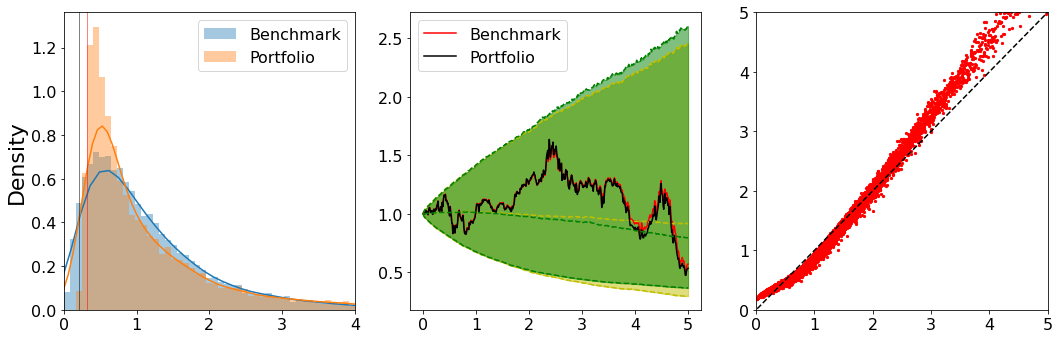

1.1358073 1.142598

..........340 duaration =  11.057  secs
Wass Dist: 0.217 Risk Measure: -12.777 Loss: -12.777


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


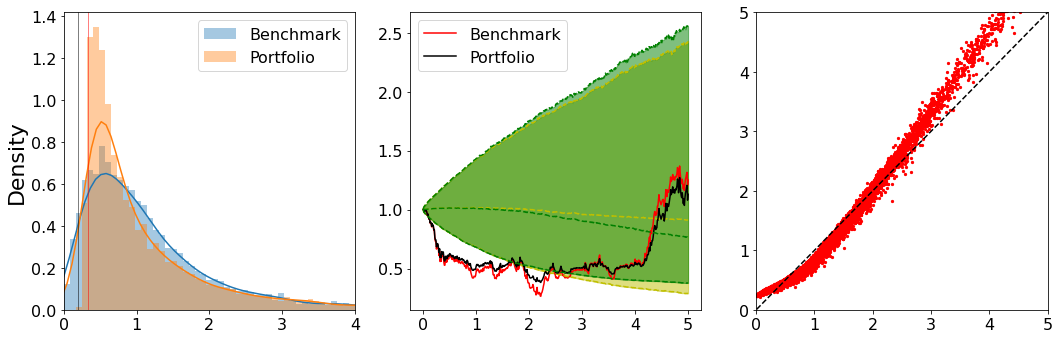

1.154395 1.160867

..........350 duaration =  11.307  secs
Wass Dist: 0.299 Risk Measure: -13.459 Loss: -13.459


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


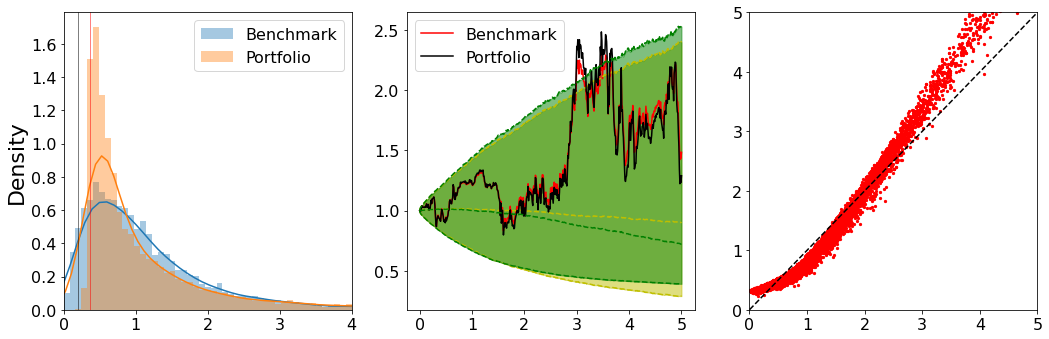

1.1353595 1.1467862

..........360 duaration =  11.569  secs
Wass Dist: 0.375 Risk Measure: -14.161 Loss: -14.161


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


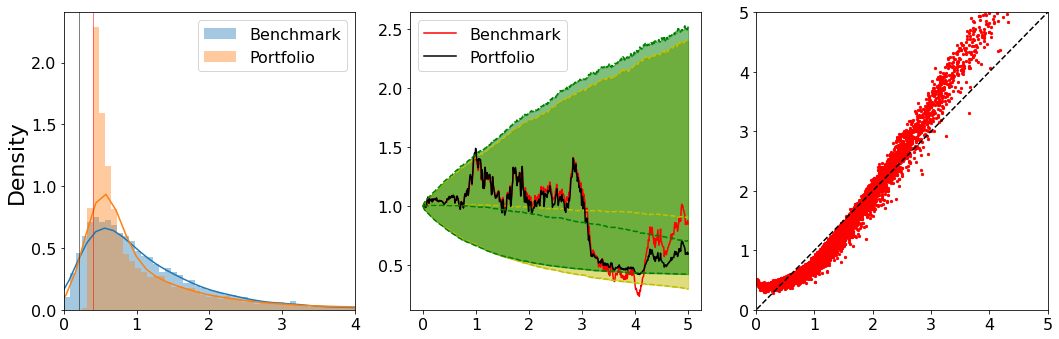

1.1430194 1.155012

..........370 duaration =  11.285  secs
Wass Dist: 0.308 Risk Measure: -13.958 Loss: -13.958


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


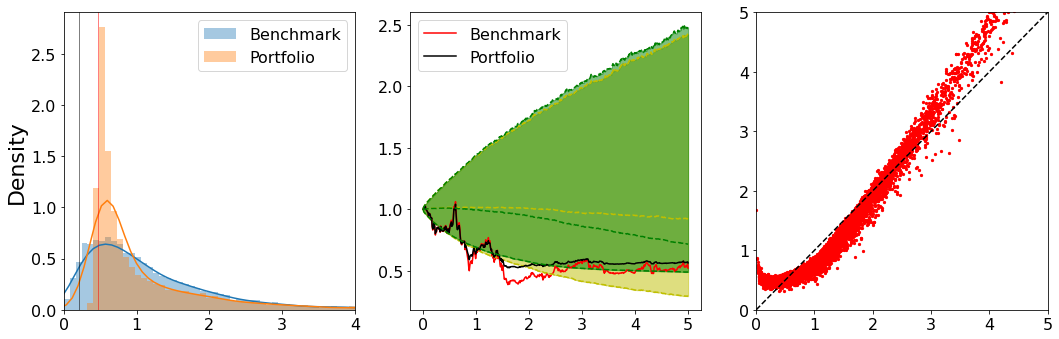

1.1500779 1.1510799

..........380 duaration =  11.028  secs
Wass Dist: 0.421 Risk Measure: -14.347 Loss: 27.757


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


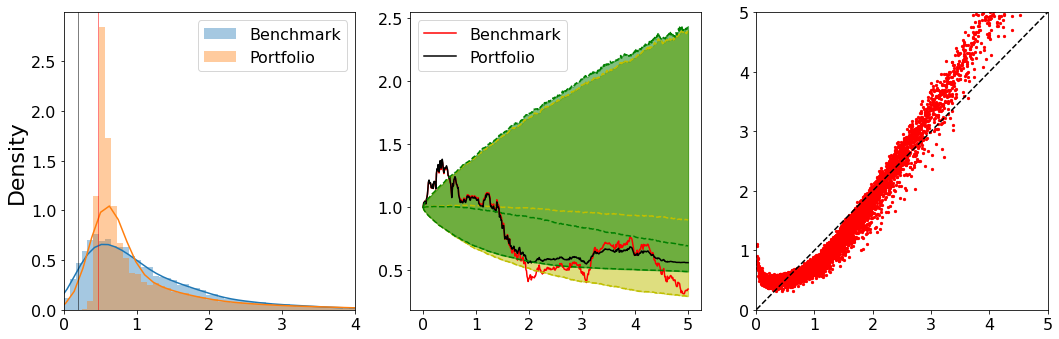

1.1545961 1.1567701

..........390 duaration =  11.158  secs
Wass Dist: 0.336 Risk Measure: -14.210 Loss: -14.210


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


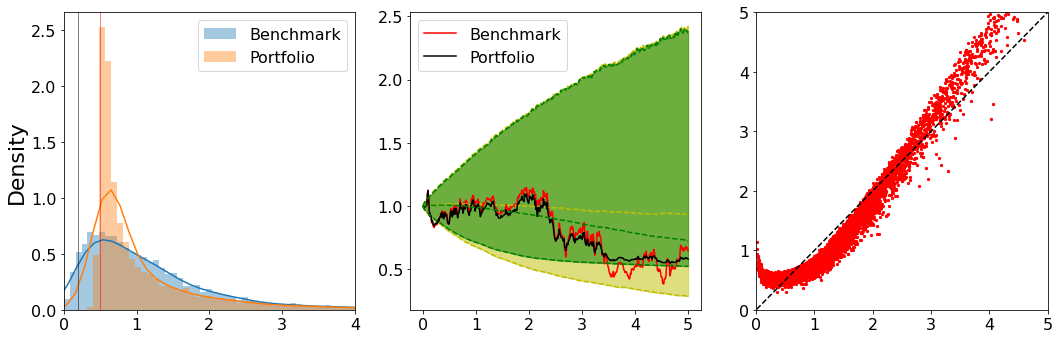

1.1526735 1.140536

..........400 duaration =  11.156  secs
Wass Dist: 0.372 Risk Measure: -14.367 Loss: -14.367


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


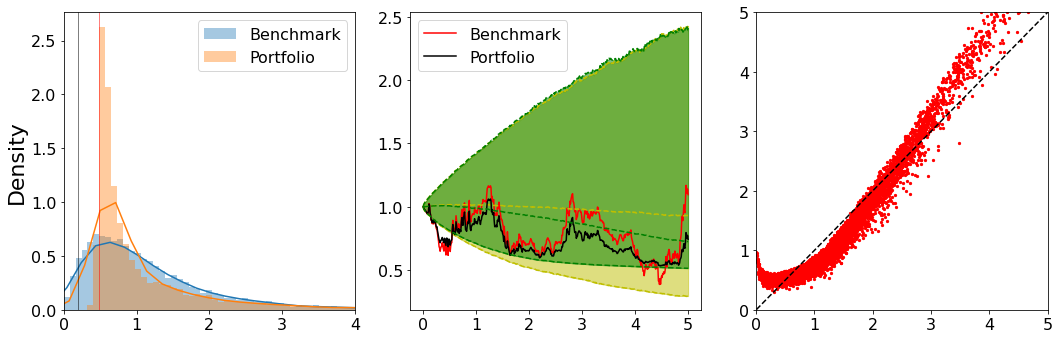

1.1579567 1.1579859

..........410 duaration =  11.213  secs
Wass Dist: 0.319 Risk Measure: -14.034 Loss: -14.034


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


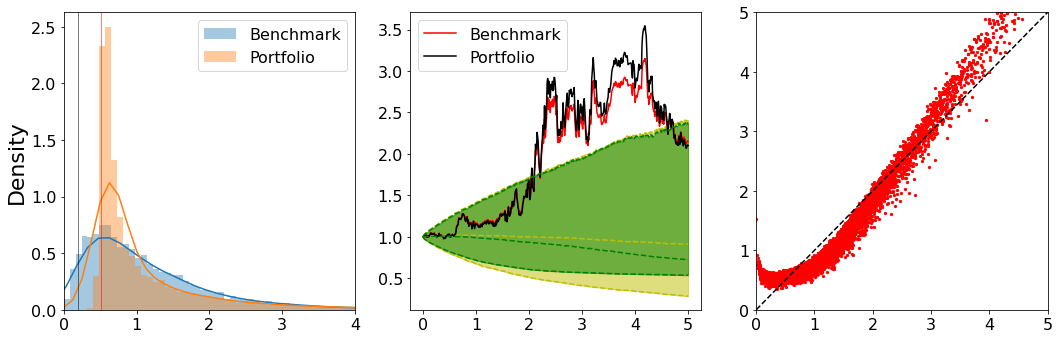

1.1450169 1.1261753

..........420 duaration =  11.076  secs
Wass Dist: 0.306 Risk Measure: -13.912 Loss: -13.912


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


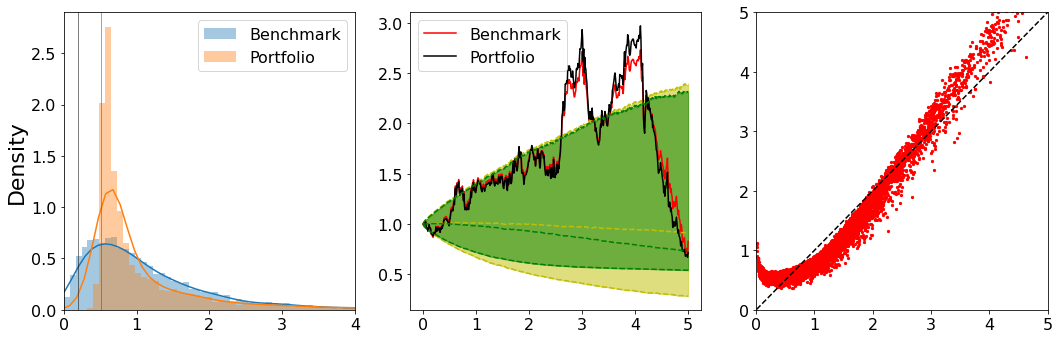

1.1595265 1.1503152

..........430 duaration =  11.379  secs
Wass Dist: 0.355 Risk Measure: -14.178 Loss: -14.178


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


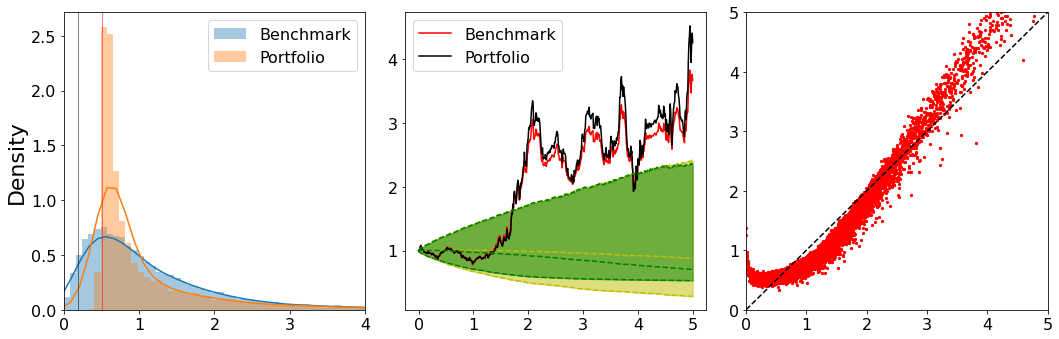

1.1729556 1.1741357

..........440 duaration =  11.162  secs
Wass Dist: 0.312 Risk Measure: -14.329 Loss: -14.329


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


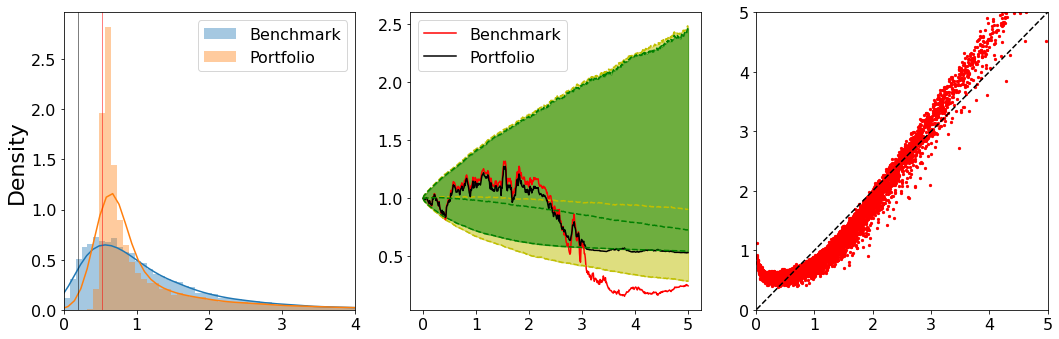

1.1503785 1.1350453

..........450 duaration =  11.009  secs
Wass Dist: 0.301 Risk Measure: -14.203 Loss: -14.203


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


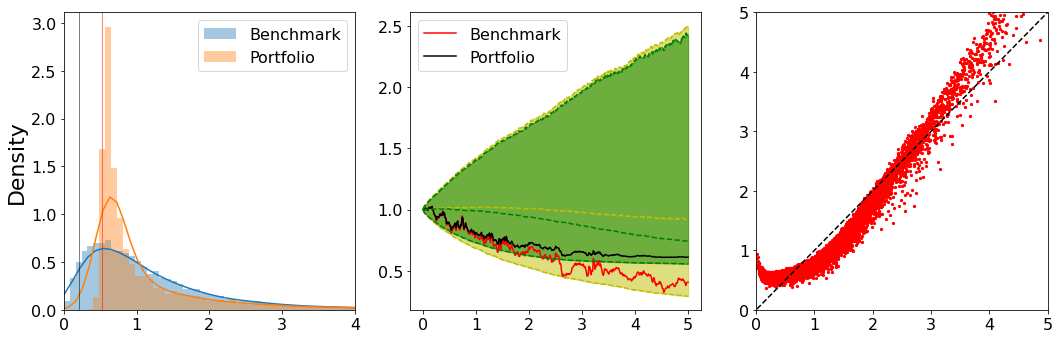

1.1673814 1.1557881

..........460 duaration =  11.429  secs
Wass Dist: 0.373 Risk Measure: -14.338 Loss: -14.338


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


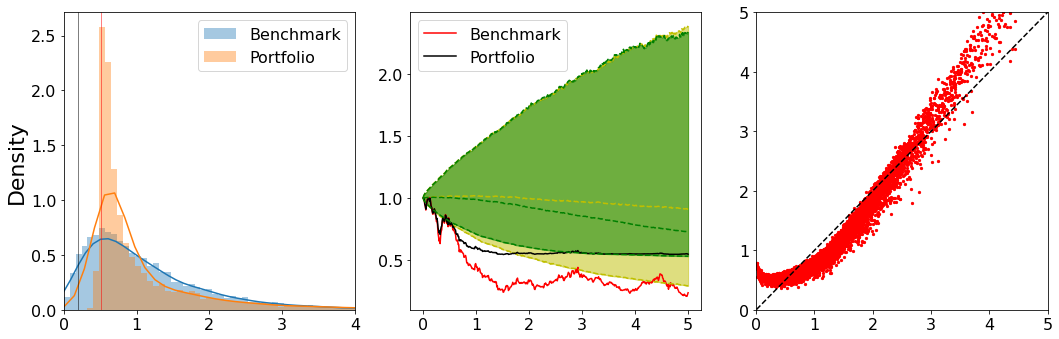

1.1607059 1.1598272

..........470 duaration =  10.987  secs
Wass Dist: 0.283 Risk Measure: -13.936 Loss: -13.936


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


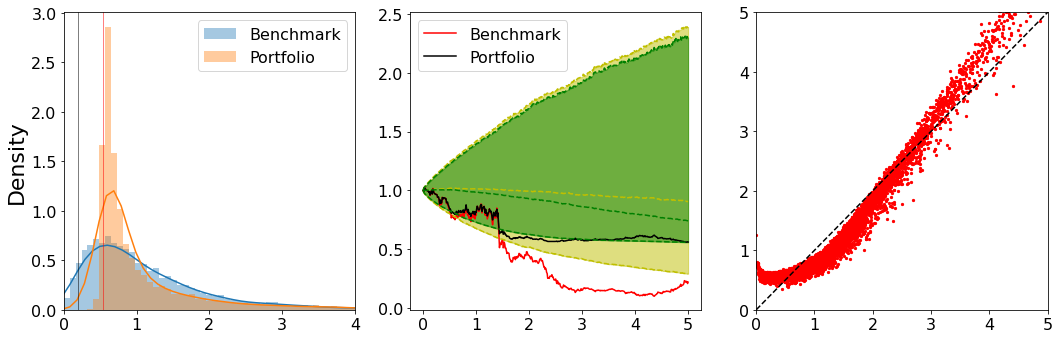

1.1593391 1.1462253

..........480 duaration =  11.111  secs
Wass Dist: 0.290 Risk Measure: -14.037 Loss: -14.037


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


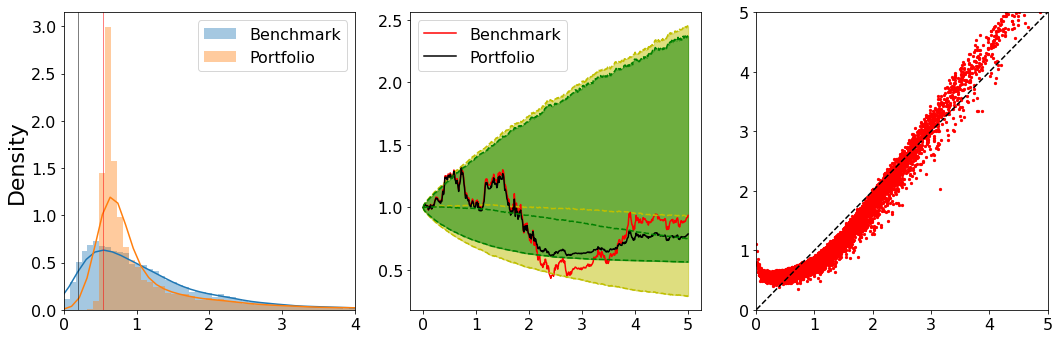

1.1677603 1.1535529

..........490 duaration =  11.389  secs
Wass Dist: 0.324 Risk Measure: -14.214 Loss: -14.214


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


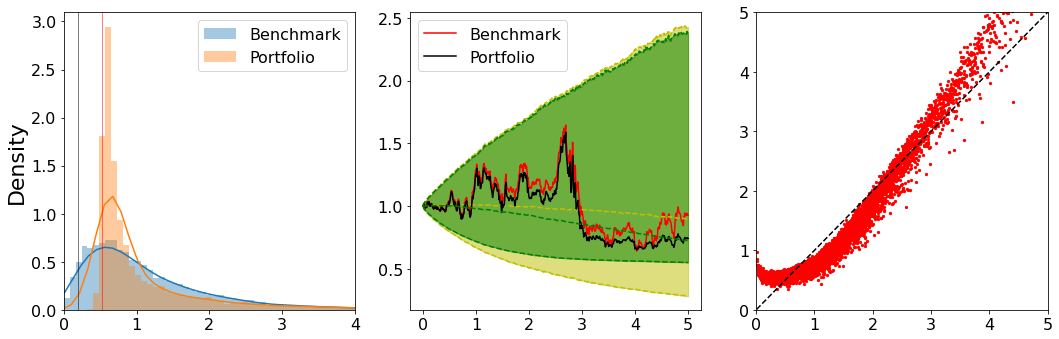

1.1499975 1.1448853

..........500 duaration =  11.122  secs
Wass Dist: 0.415 Risk Measure: -14.418 Loss: 27.074


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


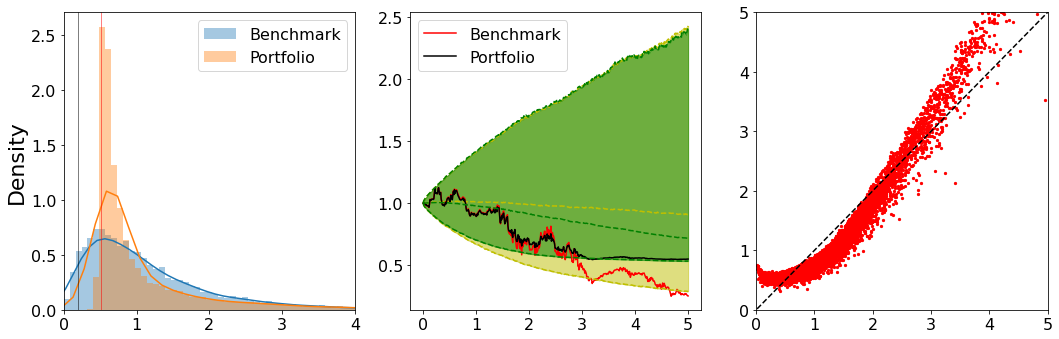

1.1361259 1.1302005

..........510 duaration =  11.155  secs
Wass Dist: 0.320 Risk Measure: -14.060 Loss: -14.060


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


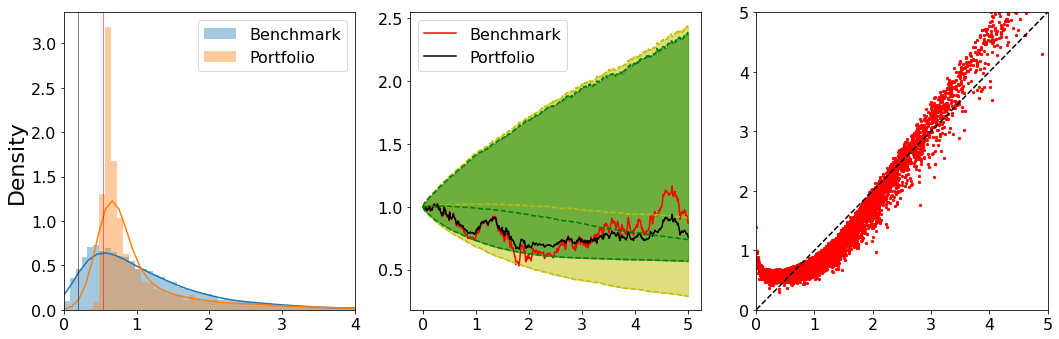

1.1592795 1.1439168

..........520 duaration =  11.529  secs
Wass Dist: 0.323 Risk Measure: -14.171 Loss: -14.171


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


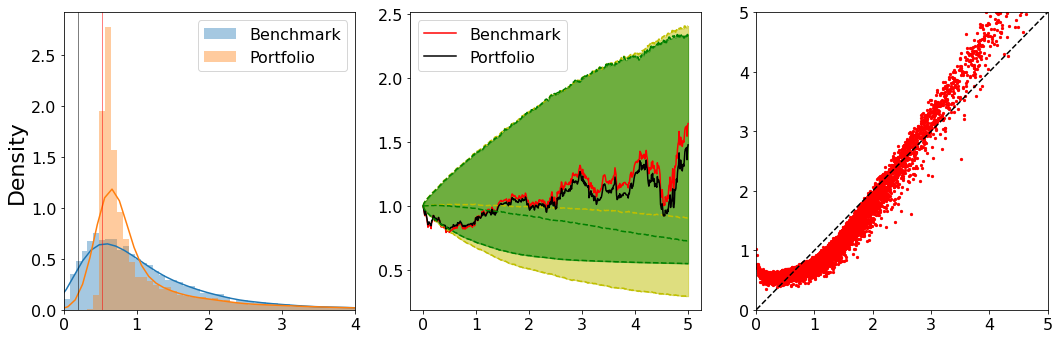

1.1566689 1.1480206

..........530 duaration =  11.217  secs
Wass Dist: 0.357 Risk Measure: -14.191 Loss: -14.191


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


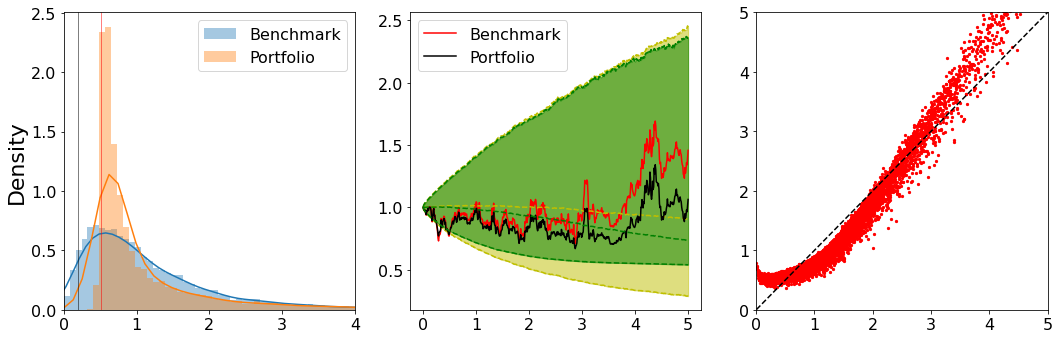

1.1435426 1.1323465

..........540 duaration =  11.759  secs
Wass Dist: 0.315 Risk Measure: -14.172 Loss: -14.172


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


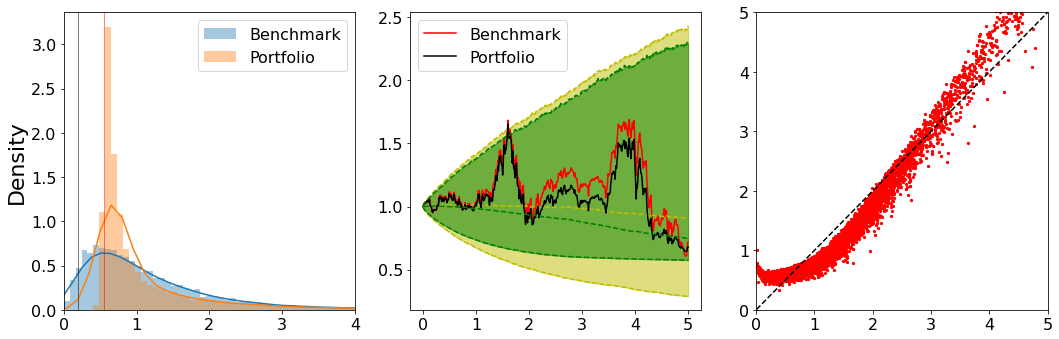

1.1572554 1.1317508

..........550 duaration =  11.337  secs
Wass Dist: 0.423 Risk Measure: -13.301 Loss: 29.034


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


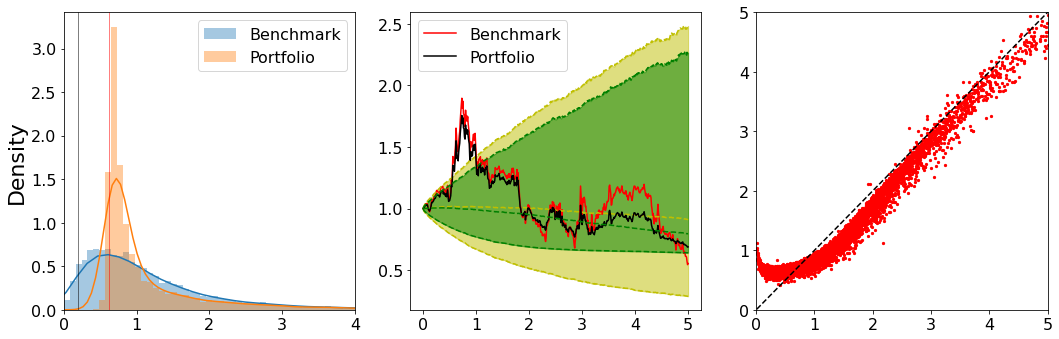

1.1638333 1.1223973

..........560 duaration =  11.255  secs
Wass Dist: 0.234 Risk Measure: -13.153 Loss: -13.153


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


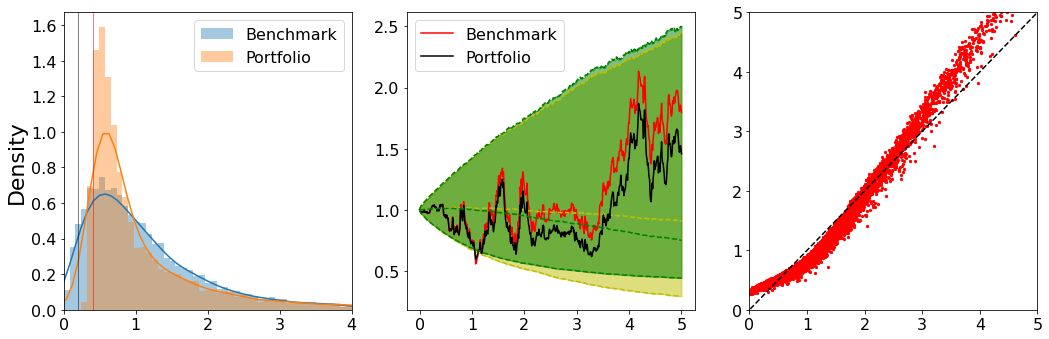

1.1386645 1.1421765

..........570 duaration =  11.595  secs
Wass Dist: 0.295 Risk Measure: -13.630 Loss: -13.630


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


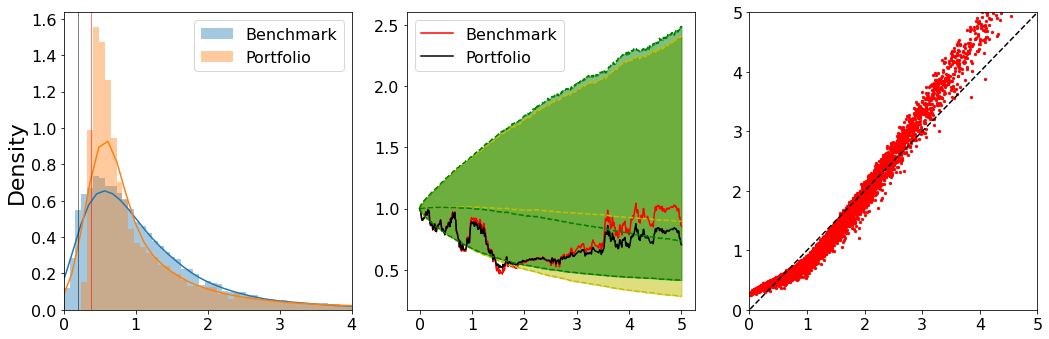

1.1391914 1.1410923

..........580 duaration =  11.106  secs
Wass Dist: 0.226 Risk Measure: -12.589 Loss: -12.589


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


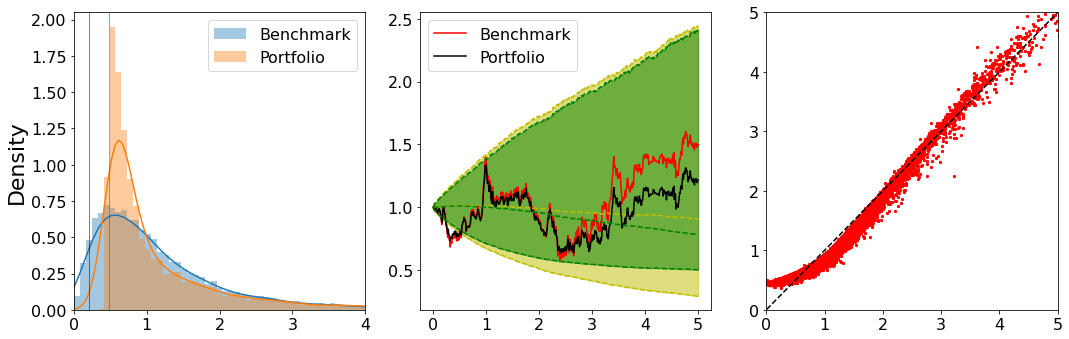

1.1566542 1.1376826

..........590 duaration =  11.074  secs
Wass Dist: 0.306 Risk Measure: -12.921 Loss: -12.921


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


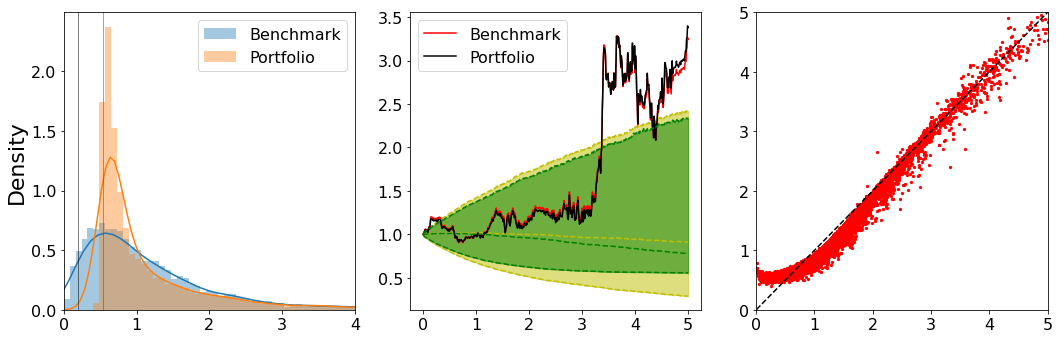

1.1581935 1.1201748

..........600 duaration =  11.345  secs
Wass Dist: 0.341 Risk Measure: -12.963 Loss: -12.963


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


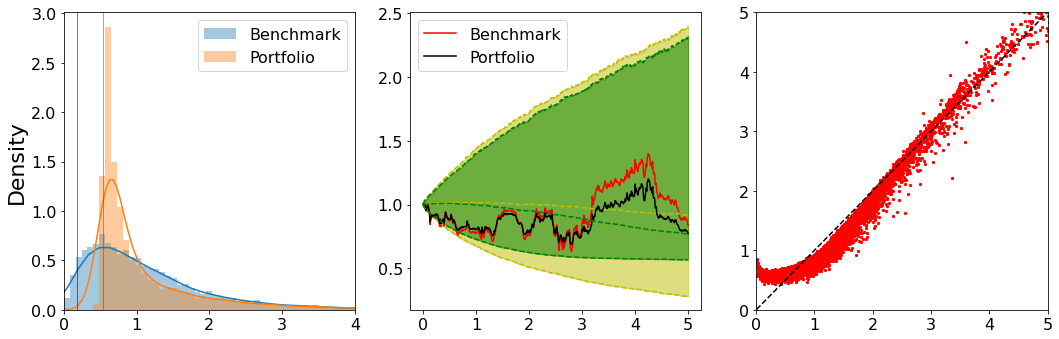

1.1322085 1.1097145

..........610 duaration =  11.415  secs
Wass Dist: 0.253 Risk Measure: -13.333 Loss: -13.333


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


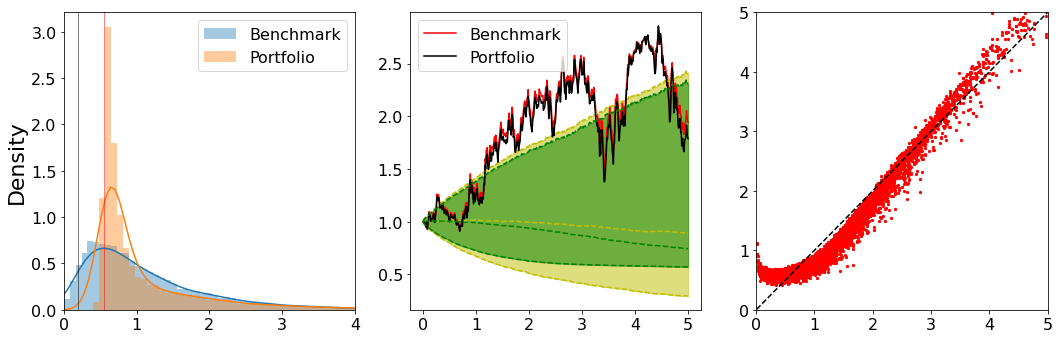

1.1561378 1.133906

..........620 duaration =  11.443  secs
Wass Dist: 0.304 Risk Measure: -13.934 Loss: -13.934


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


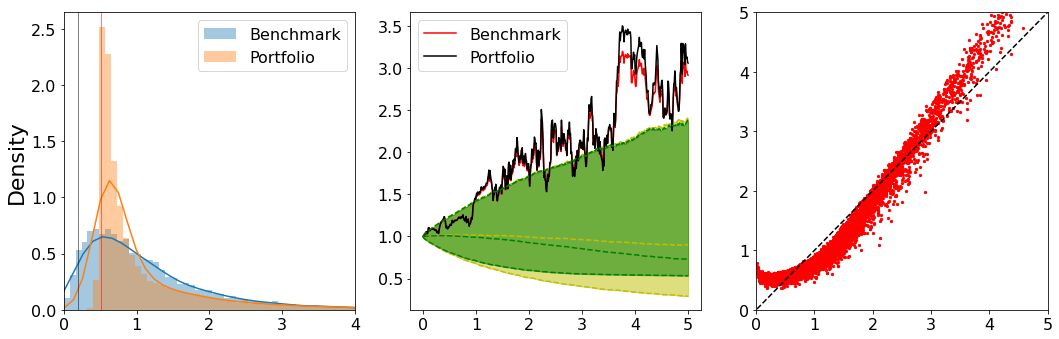

1.139576 1.1368005

..........630 duaration =  11.523  secs
Wass Dist: 0.343 Risk Measure: -14.210 Loss: -14.210


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


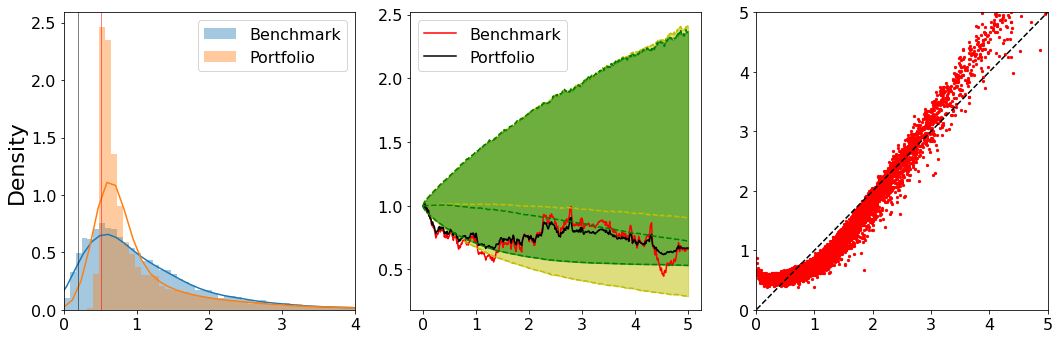

1.1590416 1.1547244

..........640 duaration =  11.276  secs
Wass Dist: 0.308 Risk Measure: -14.151 Loss: -14.151


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


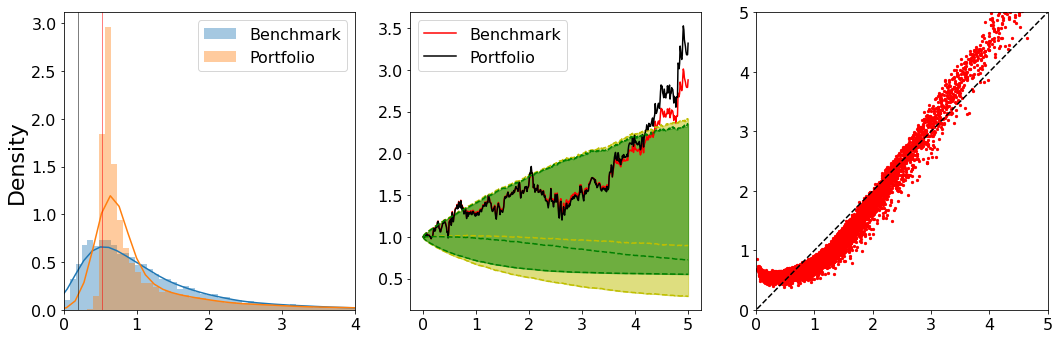

1.1480225 1.131641

..........650 duaration =  11.469  secs
Wass Dist: 0.343 Risk Measure: -14.127 Loss: -14.127


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


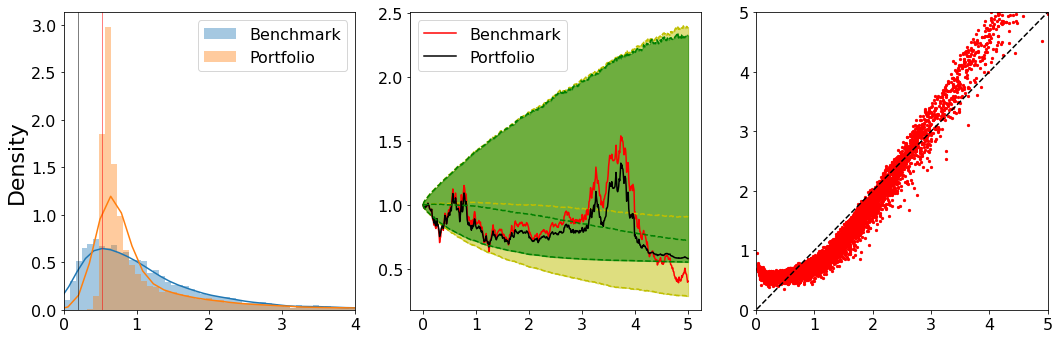

1.1364152 1.1247559

..........660 duaration =  11.084  secs
Wass Dist: 0.358 Risk Measure: -14.158 Loss: -14.158


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


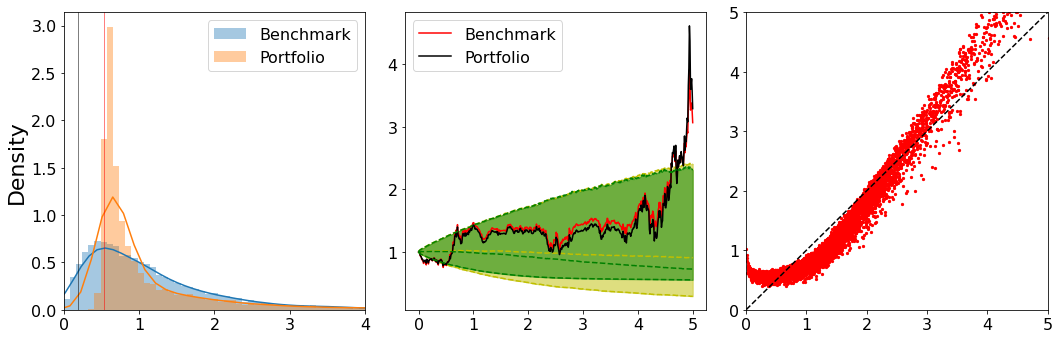

1.1491919 1.1398429

..........670 duaration =  11.361  secs
Wass Dist: 0.312 Risk Measure: -13.918 Loss: -13.918


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


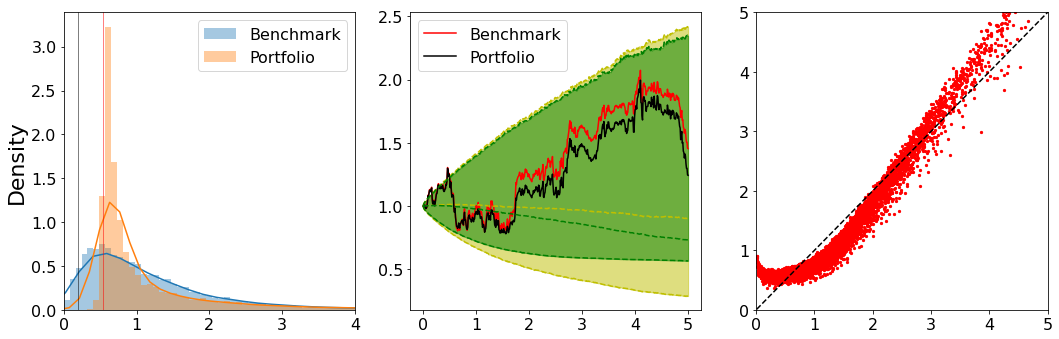

1.1588658 1.1452178

..........680 duaration =  11.508  secs
Wass Dist: 0.319 Risk Measure: -14.018 Loss: -14.018


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


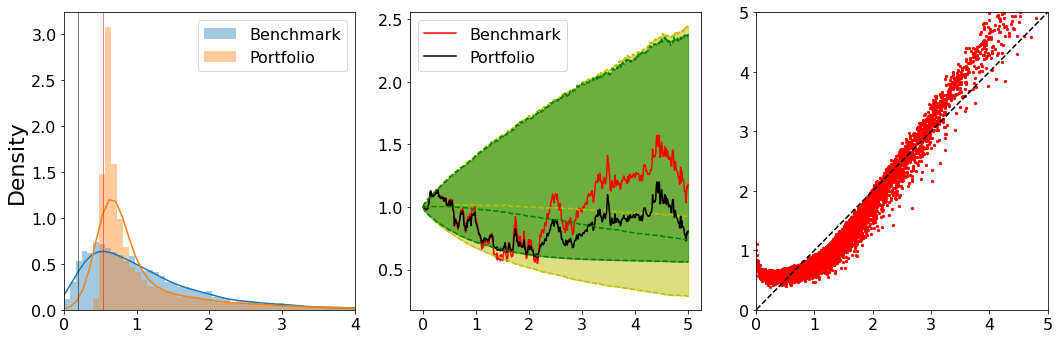

1.1505648 1.1416904

..........690 duaration =  11.232  secs
Wass Dist: 0.374 Risk Measure: -14.654 Loss: -14.654


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


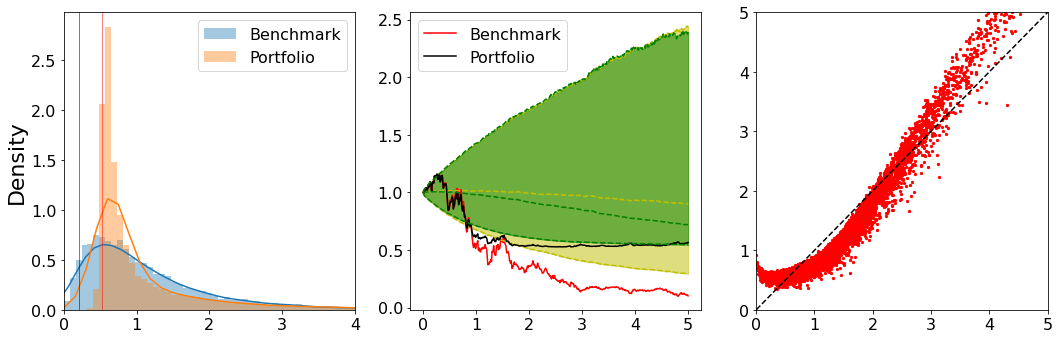

1.1458504 1.1366565

..........700 duaration =  11.312  secs
Wass Dist: 0.315 Risk Measure: -14.159 Loss: -14.159


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


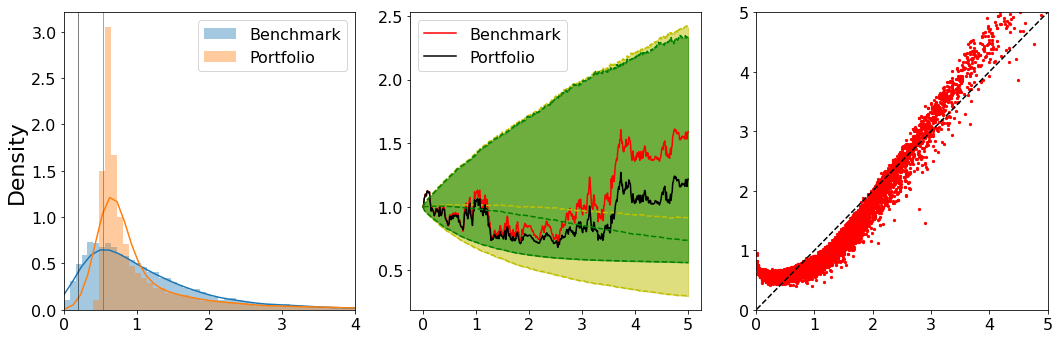

1.1293888 1.1147311

..........710 duaration =  11.575  secs
Wass Dist: 0.324 Risk Measure: -14.283 Loss: -14.283


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


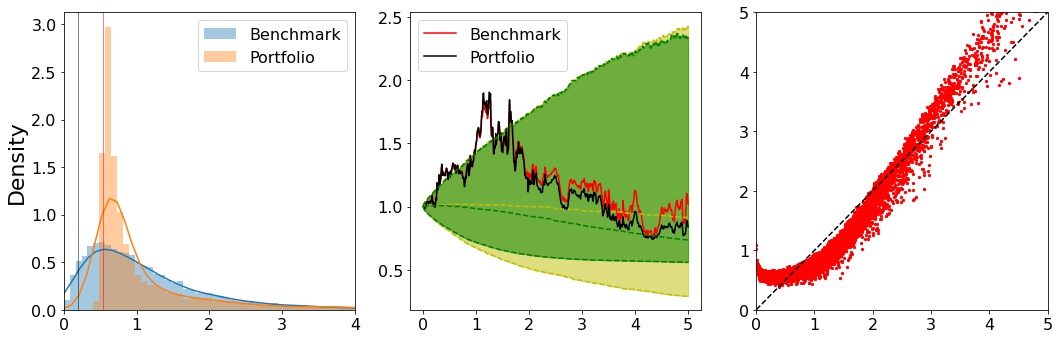

1.1534183 1.1405808

..........720 duaration =  11.466  secs
Wass Dist: 0.448 Risk Measure: -14.506 Loss: 30.267


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


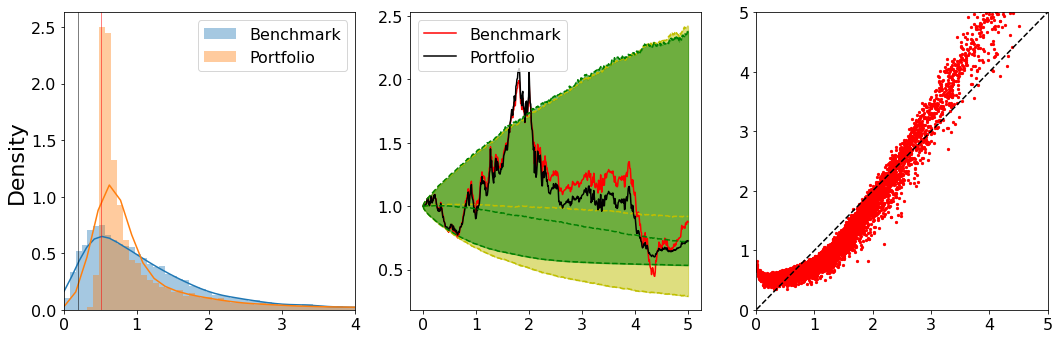

1.1595981 1.1521614

..........730 duaration =  11.659  secs
Wass Dist: 0.307 Risk Measure: -13.287 Loss: -13.287


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


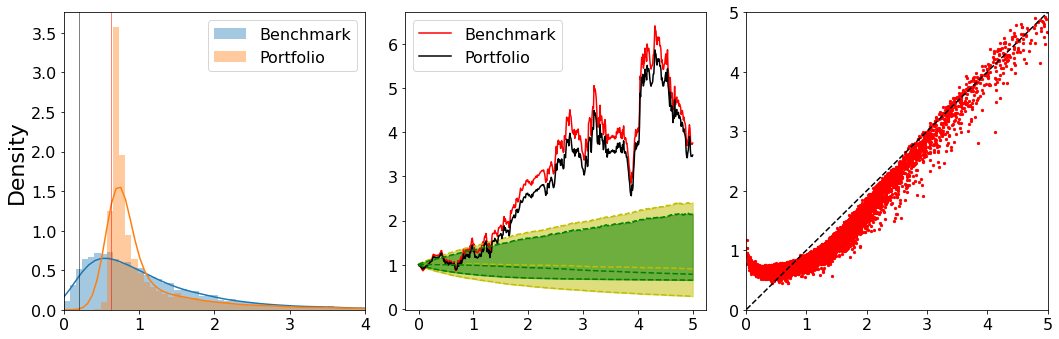

1.1496233 1.1064168

..........740 duaration =  11.584  secs
Wass Dist: 0.386 Risk Measure: -13.331 Loss: -13.331


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


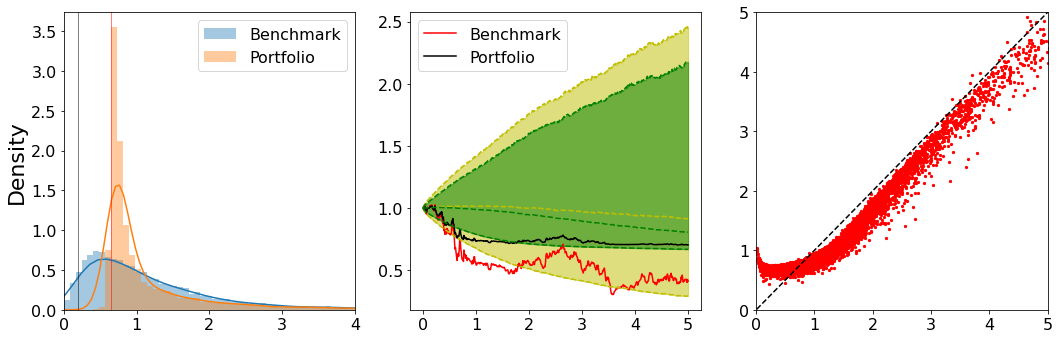

1.1491616 1.1032943

..........750 duaration =  11.341  secs
Wass Dist: 0.538 Risk Measure: -13.141 Loss: 40.657


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


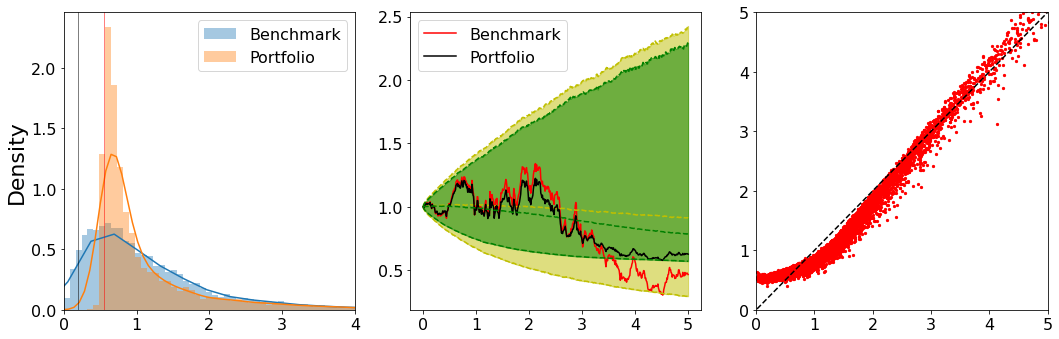

1.1417121 1.1194017

..........760 duaration =  11.663  secs
Wass Dist: 0.224 Risk Measure: -13.357 Loss: -13.357


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


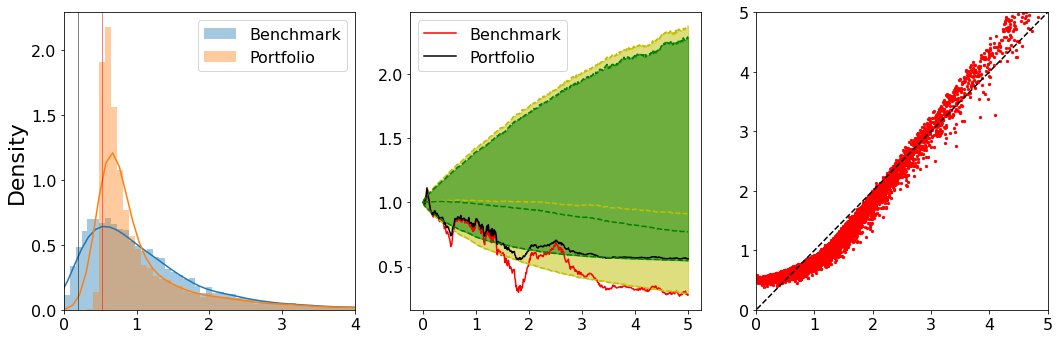

1.1645603 1.1383097

..........770 duaration =  11.356  secs
Wass Dist: 0.591 Risk Measure: -12.896 Loss: 46.213


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


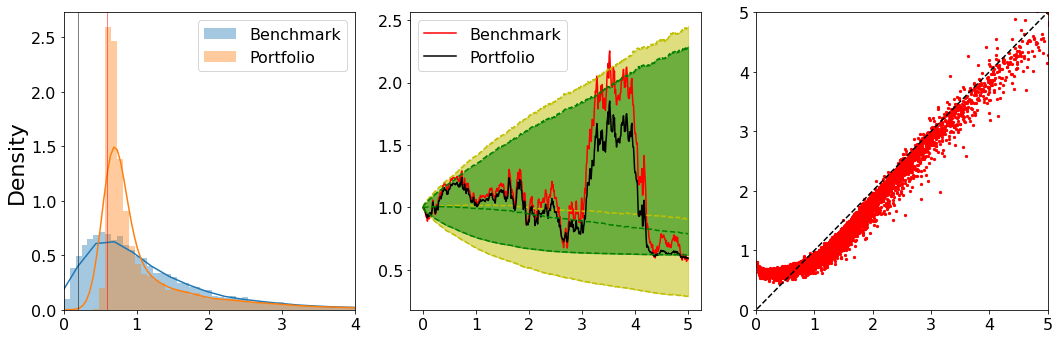

1.1484258 1.1117108

..........780 duaration =  11.415  secs
Wass Dist: 0.202 Risk Measure: -13.122 Loss: -13.122


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


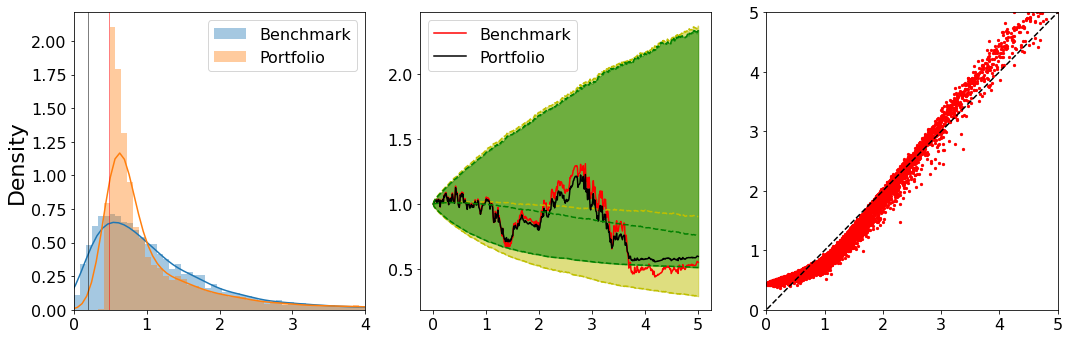

1.159498 1.1493231

..........790 duaration =  11.869  secs
Wass Dist: 0.280 Risk Measure: -13.717 Loss: -13.717


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


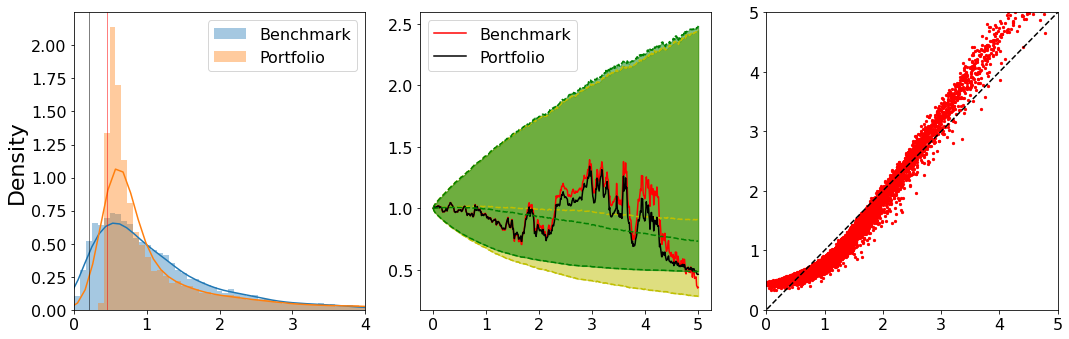

1.1527402 1.1503989

..........800 duaration =  11.418  secs
Wass Dist: 0.400 Risk Measure: -14.389 Loss: -14.389


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


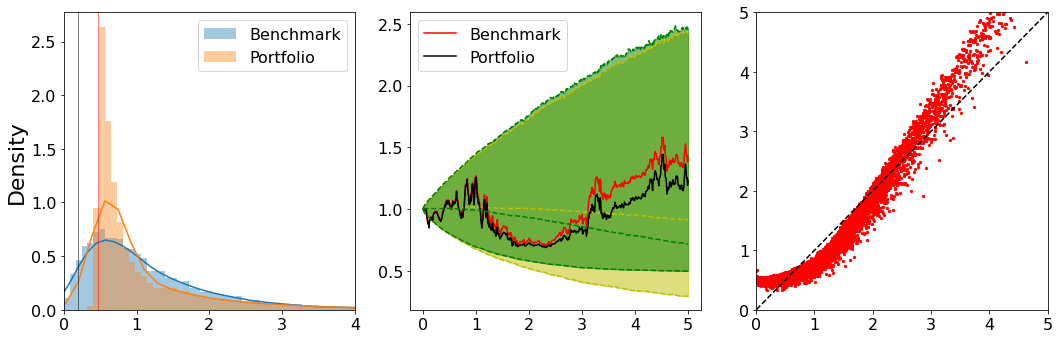

1.1364036 1.1346813

..........810 duaration =  11.658  secs
Wass Dist: 0.278 Risk Measure: -13.826 Loss: -13.826


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


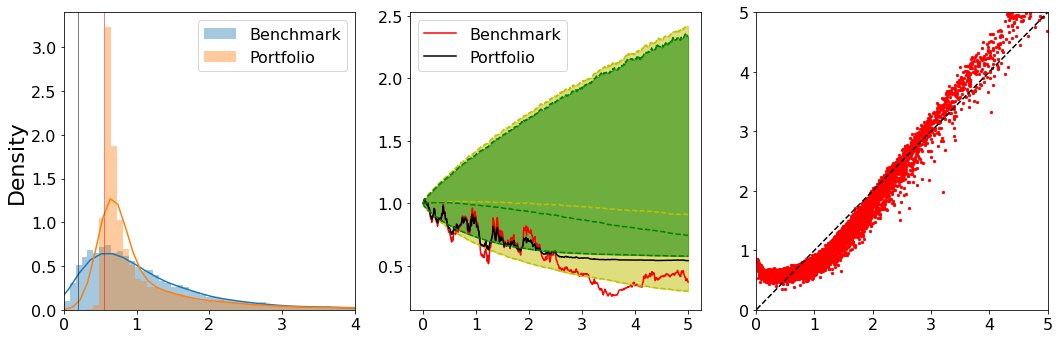

1.1454756 1.1208578

..........820 duaration =  11.432  secs
Wass Dist: 0.340 Risk Measure: -13.415 Loss: -13.415


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


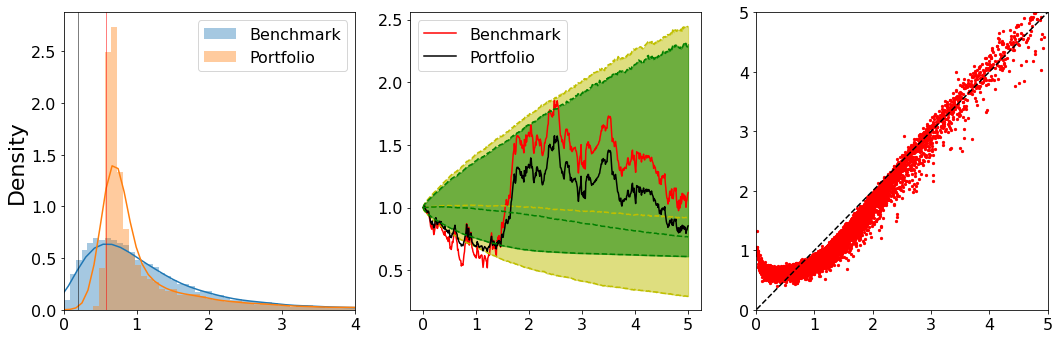

1.1423607 1.1083542

..........830 duaration =  11.599  secs
Wass Dist: 0.304 Risk Measure: -13.463 Loss: -13.463


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


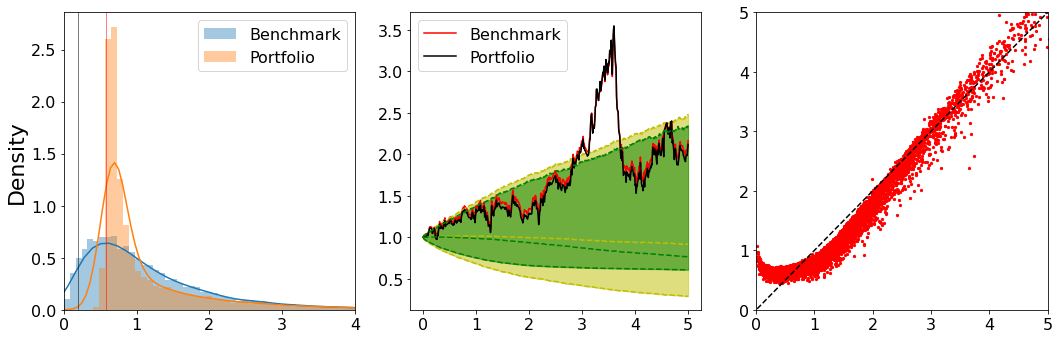

1.1404123 1.1106546

..........840 duaration =  11.270  secs
Wass Dist: 0.265 Risk Measure: -13.898 Loss: -13.898


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


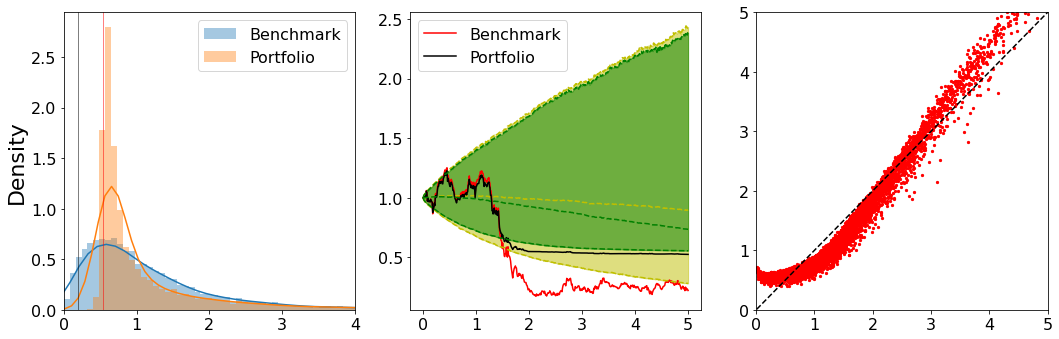

1.1576684 1.1454906

..........850 duaration =  11.350  secs
Wass Dist: 0.319 Risk Measure: -14.280 Loss: -14.280


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


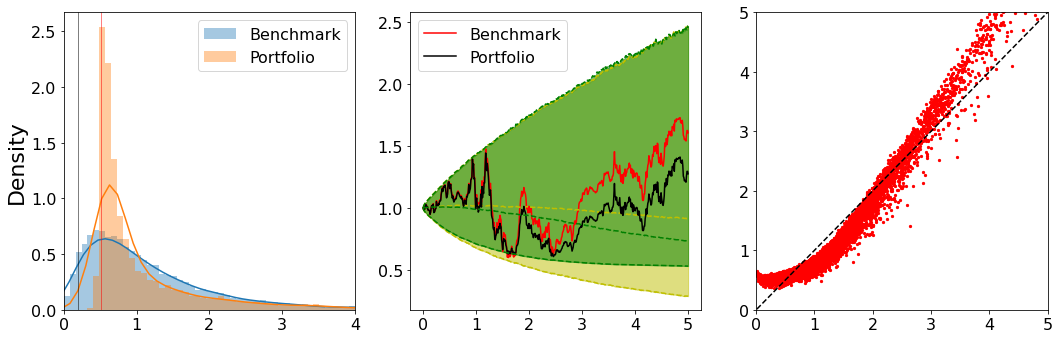

1.150888 1.1435001

..........860 duaration =  11.427  secs
Wass Dist: 0.294 Risk Measure: -13.987 Loss: -13.987


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


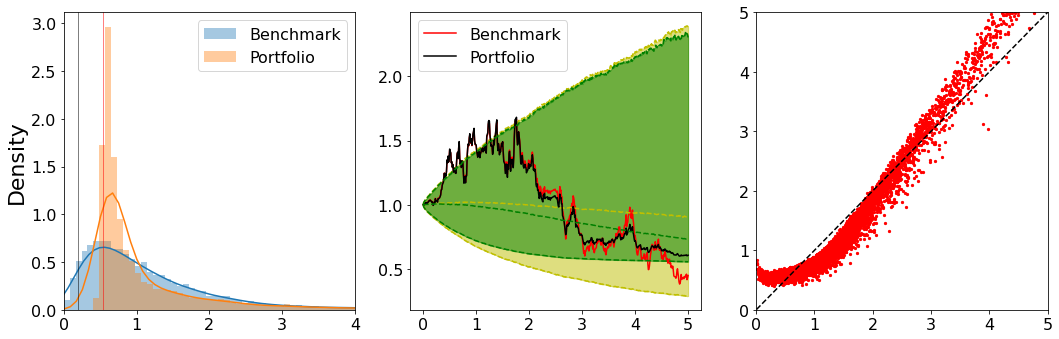

1.126337 1.109558

..........870 duaration =  11.594  secs
Wass Dist: 0.328 Risk Measure: -13.940 Loss: -13.940


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


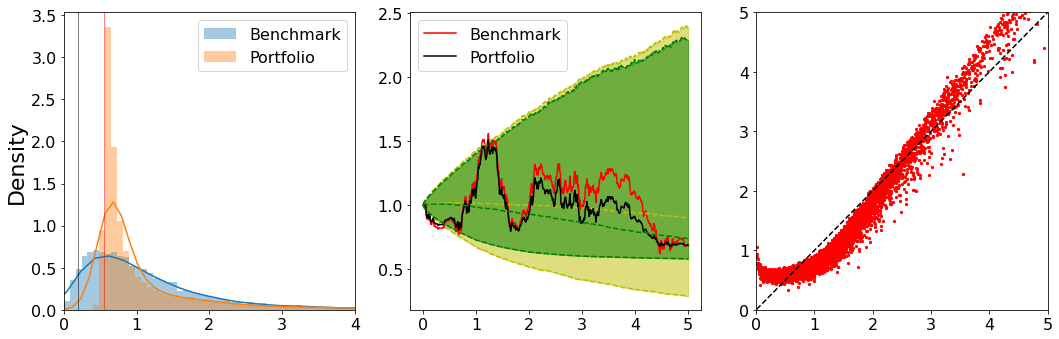

1.1433438 1.1197916

..........880 duaration =  11.607  secs
Wass Dist: 0.406 Risk Measure: -14.444 Loss: 26.179


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


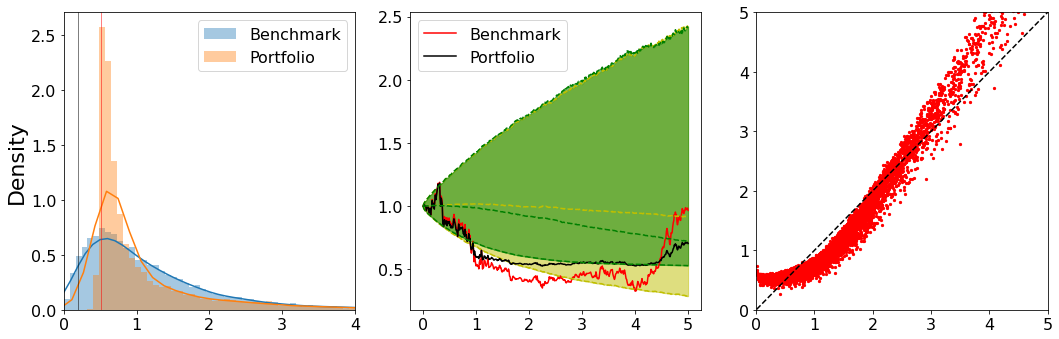

1.1739233 1.1757307

..........890 duaration =  11.307  secs
Wass Dist: 0.264 Risk Measure: -13.517 Loss: -13.517


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


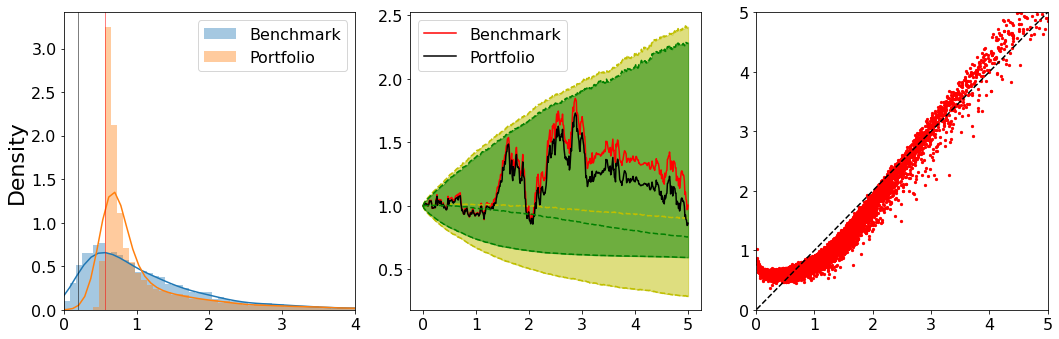

1.1690817 1.1391617

..........900 duaration =  11.633  secs
Wass Dist: 0.299 Risk Measure: -13.402 Loss: -13.402


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


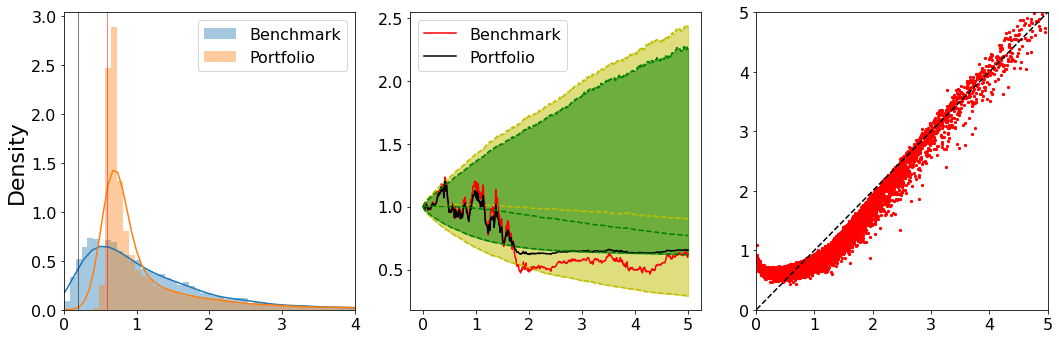

1.150963 1.1200693

..........910 duaration =  11.267  secs
Wass Dist: 0.287 Risk Measure: -13.530 Loss: -13.530


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


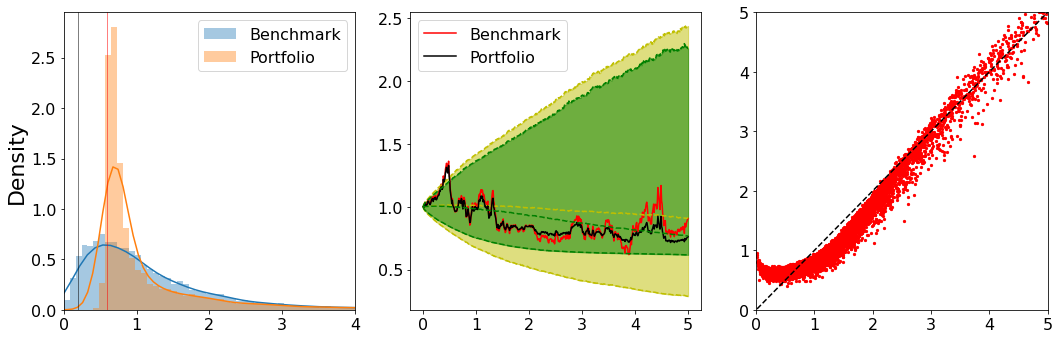

1.1504052 1.1193391

..........920 duaration =  11.307  secs
Wass Dist: 0.273 Risk Measure: -14.011 Loss: -14.011


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


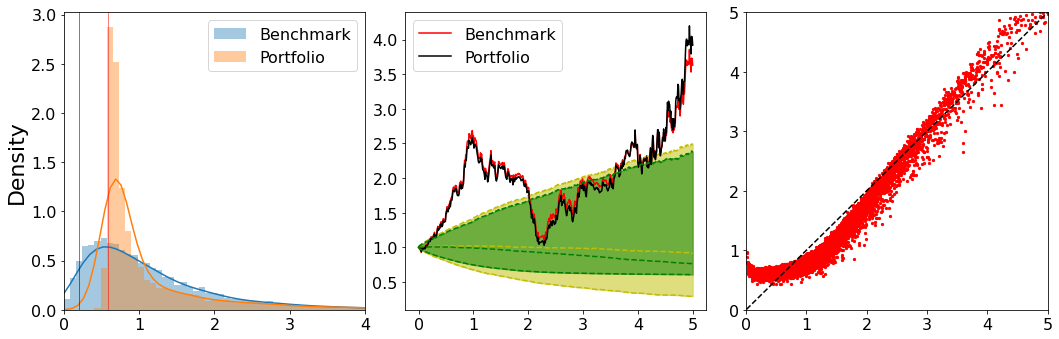

1.1483408 1.1231068

..........930 duaration =  11.579  secs
Wass Dist: 0.281 Risk Measure: -14.109 Loss: -14.109


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


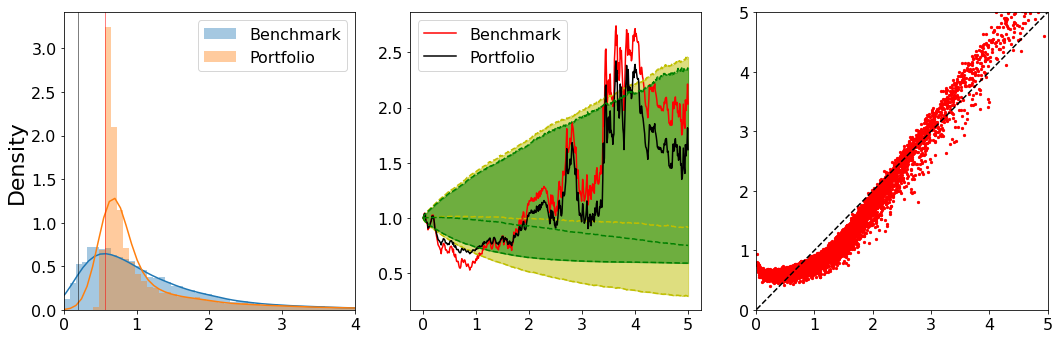

1.1597627 1.1381544

..........940 duaration =  11.617  secs
Wass Dist: 0.300 Risk Measure: -13.570 Loss: -13.570


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


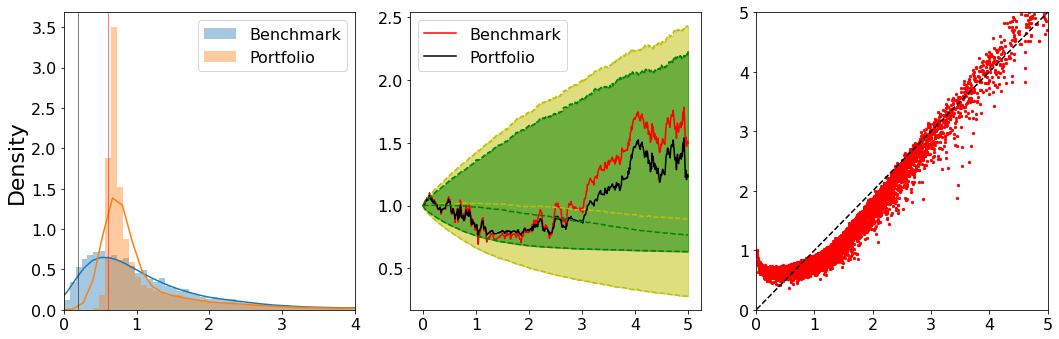

1.1531634 1.1133068

..........950 duaration =  11.213  secs
Wass Dist: 0.326 Risk Measure: -12.468 Loss: -12.468


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


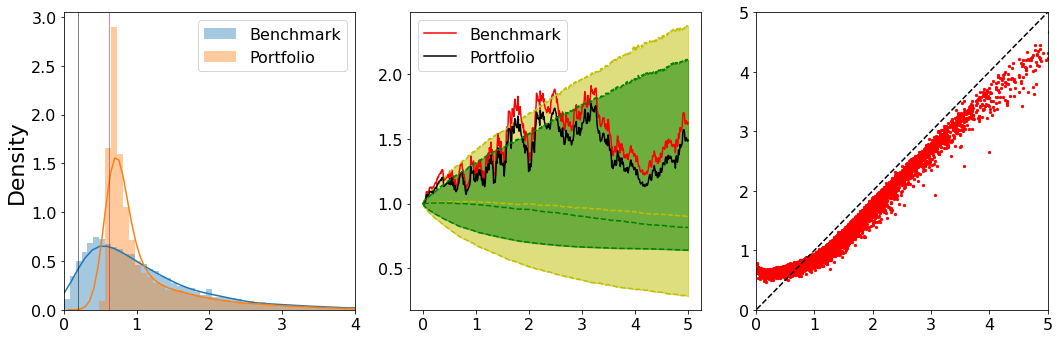

1.1326277 1.0944303

..........960 duaration =  11.335  secs
Wass Dist: 0.245 Risk Measure: -12.487 Loss: -12.487


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


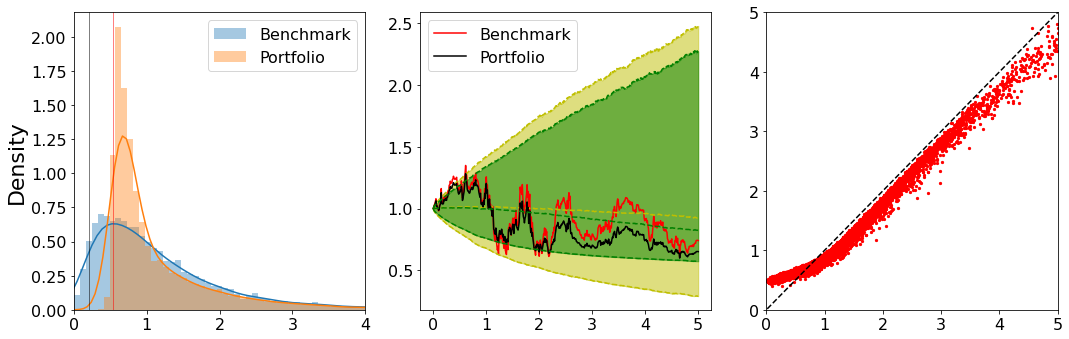

1.1649187 1.1263144

..........970 duaration =  11.291  secs
Wass Dist: 0.238 Risk Measure: -12.699 Loss: -12.699


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


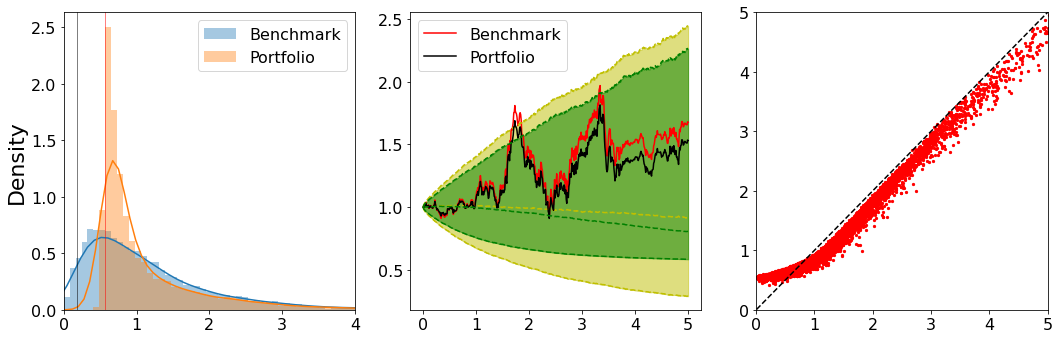

1.1448804 1.1136578

..........980 duaration =  11.460  secs
Wass Dist: 0.267 Risk Measure: -12.931 Loss: -12.931


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


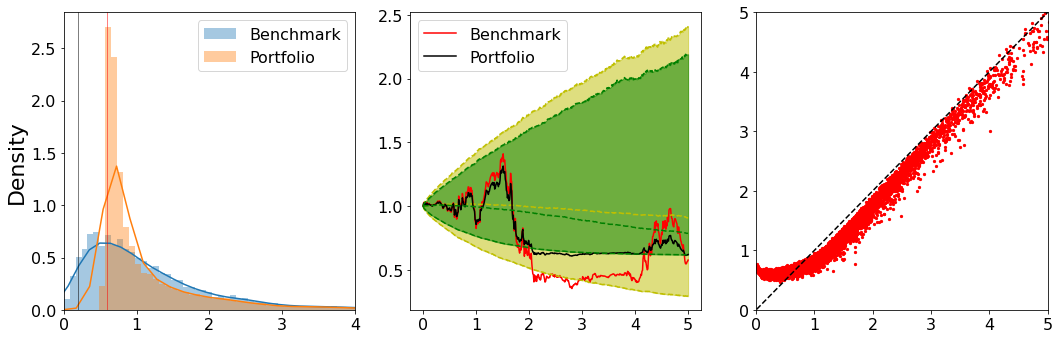

1.1623379 1.1301777

..........990 duaration =  11.430  secs
Wass Dist: 0.272 Risk Measure: -13.287 Loss: -13.287


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


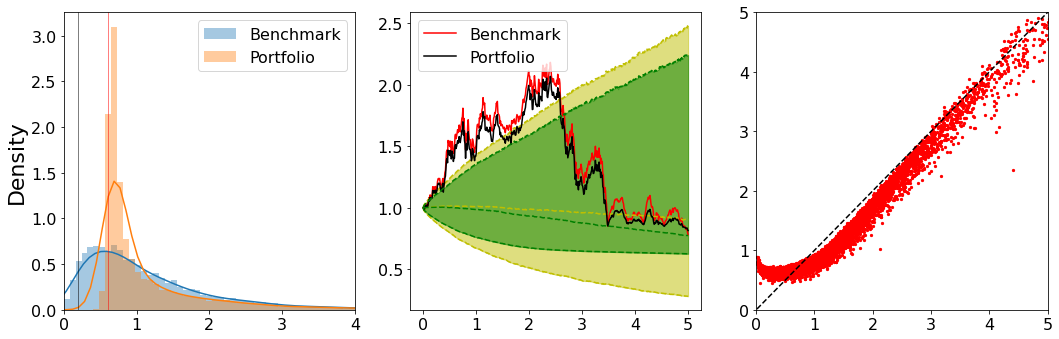

1.1498754 1.116485

.........Finished Training


In [36]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 1000
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, RiskMeasure, wass_dist, PortfolioVal_T, IndexVal_T, t, IndexVal_path, PortfolioVal_path \
        = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = 100*(wass_dist)*(wass_dist>0.4) + RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 10 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
        print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
        print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists(IndexVal_T, PortfolioVal_T, t, IndexVal_path, PortfolioVal_path)
                
        
        _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
        print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
        print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [37]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

1.1188457965976173 1.1167686107201573



In [38]:
X_delta_T.shape

(110000, 1)

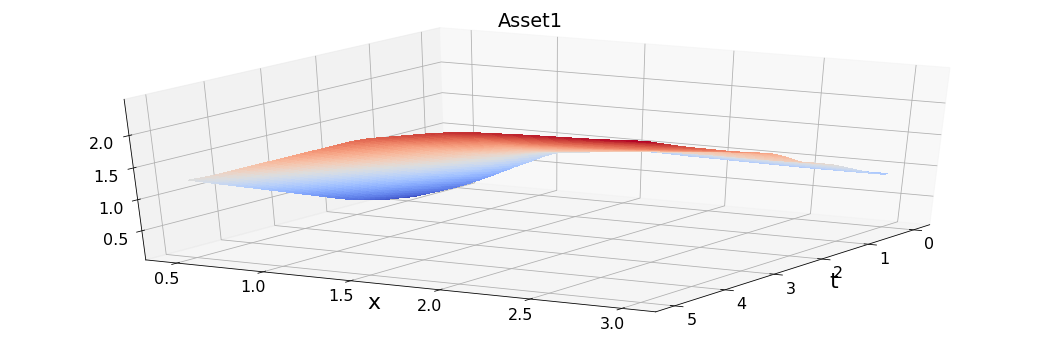

In [39]:
def PlotStrat(net, device):
    
    t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,i]/params["delta"][i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,3,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,3,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])

    #     plt.subplot(1,3,3)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

### Backtesting

In [40]:
#backtesting_params = params

# backtesting_params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.3]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

backtesting_params = {
    "S0" : np.array([1, 1]),
    "mu" : np.array([0.05, 0.05]),
    "sigma" : np.array([0.1, 0.8]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.5, 0.5])
    }

# backtesting_params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.30 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1, params=backtesting_params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)

/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = N.array(data, dtype=dtype, copy=copy)


ValueError: ignored

In [ ]:
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,0], label='Asset1', color='r')
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,1], label='Asset2', color='b')
plt.legend()

In [ ]:
wt

In [ ]:
#%debug

In [ ]:
import pickle 

In [ ]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )